## Requirement : medical price depends on various factors such as resolution, brand, size, weight, imaging quality, RAM, battery and cpu power. In this dataset, we want to estimate the price of medical phones using the above features

#### i.	Download the dataset from above link and load it into your Python environment.
#### ii.	Perform the EDA and do the visualizations.
#### iii.	Check the distributions/skewness in the variables and do the transformations if required.
#### iv.	Check/Treat the outliers and do the feature scaling if required.
#### v.	Create a ML model to predict the price of the phone based on the specifications given.
#### vi.	Check for overfitting and use the Regularization techniques if required
#### vii.	Compare the performance metrics of training dataset and testing dataset for all the different algorithms used (Linear/Ridge/Lasso/ElasticNet)


<div style="background-color: #322f3d; color: white; padding: 15px; border-radius: 8px; font-size: 20px; font-weight: bold;">
  <span style="color: orange;">1</span> | Importing Libraries
</div>

In [276]:
import warnings
warnings.filterwarnings('ignore')

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import xgboost as xgb
import missingno as msno

from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
#from statsforecast.losses import smape
from pandas.plotting import scatter_matrix
from scipy.stats import skew ,boxcox
from sklearn.ensemble import GradientBoostingRegressor , RandomForestRegressor , AdaBoostClassifier
from sklearn.linear_model import  ElasticNet, Lasso, LinearRegression, Ridge , LassoCV , RidgeCV , ElasticNetCV 
from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score , train_test_split , KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler ,RobustScaler

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

from scipy.special import inv_boxcox 
from scipy.stats import yeojohnson


from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PowerTransformer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import pandas as pd
import numpy as np
from scipy.stats import boxcox, yeojohnson, skew

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor


sns.set()
%matplotlib inline

### Libraries Used

In [277]:
libraries = {
    "numpy": "np",
    "pandas": "pd",
    "scipy": "scipy",
    "statsmodels": "statsmodels",
    "matplotlib": "matplotlib",
    "seaborn": "sns",
    "plotly": "plotly",
    "scikit-learn": "sklearn",
    "xgboost": "xgboost",
    "catboost": "catboost",
    "lightgbm": "lightgbm"
}

# Dictionary to store library versions
library_versions = {}

# Check and print versions for each library
for lib in libraries.keys():
    try:
        # Special case for scikit-learn to debug the import explicitly
        if lib == "scikit-learn":
            import sklearn
            library_versions[lib] = sklearn.__version__
        else:
            module = __import__(lib)
            library_versions[lib] = module.__version__
    except ModuleNotFoundError:
        library_versions[lib] = "Not installed"
    except Exception as e:
        library_versions[lib] = f"Error: {str(e)}"

# Display results
for lib, version in library_versions.items():
    if version == "Not installed":
        print(f"{lib}: Not installed. Install using 'pip install {lib}'")
    else:
        print(f"{lib}: {version}")


numpy: 1.26.4
pandas: 2.2.2
scipy: 1.15.3
statsmodels: 0.14.2
matplotlib: 3.9.2
seaborn: 0.13.2
plotly: 5.24.1
scikit-learn: 1.5.1
xgboost: 3.0.0
catboost: 1.2.8
lightgbm: 4.6.0


# Explorative Data Analysis

## Data Read

In [278]:
name ="medical"

In [279]:
medical = pd.read_excel("Medical Insurance cost prediction.xlsm")

In [280]:
medical

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [281]:
#medical = medical.drop(columns="Product_id")

#  Data Encoding on RAW Data

✅ Recommended Preprocessing Plan
`Column	Encoding Type	Transformation	Scaling	Reasoning`
age	   ❌ Not needed	None or Yeo-Johnson	✅ StandardScaler	Continuous, near-normal
sex	   Label Encoding (0/1)	None	❌ No	Binary category
bmi	  ❌ Not needed	Yeo-Johnson	✅ StandardScaler	Skewed continuous
children	❌ Not needed	None	✅ StandardScaler	Integer, treat as numeric
smoker	Label Encoding (0/1)	None	❌ No	Strong binary predictor
region	One-Hot Encoding	None	❌ No	Nominal (non-ordinal) with 4 unique values
charges	— target variable	Log or Yeo-Johnson	❌ No (unless model requires)	Highly skewed, continuous target
⚠️ Additional Notes
Label Encoding is safe for binary categorical (sex, smoker) even in linear models.
One-Hot Encoding is preferred for region because:
It is nominal.
It has low cardinality (4 categories).
Transform charges using log1p or yeojohnson() to reduce skew and stabilize variance.
Scale only numeric features (age, bmi, children) if using distance-based or linear models.

✅ Final Preprocessing Pipeline Summary
Encode sex and smoker using LabelEncoder (Male/Female → 1/0, Yes/No → 1/0)
One-Hot encode region (northeast, northwest, etc.)
Apply Yeo-Johnson to bmi, optionally to age
Apply log1p to charges (target)
Standard Scale: age, bmi, children

## target encoding

In [ ]:
# Define features and target
X = medical.drop("charges", axis=1)
y = medical["charges"]

label_encoders = {}
for col in ['sex', 'smoker']:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

# Define transformations
numeric_cols = ['age', 'children']
bmi_col = ['bmi']
region_col = ['region']

# Column transformer
preprocessor = ColumnTransformer([
    ("num_scaler", StandardScaler(), numeric_cols),
    ("bmi_transform", PowerTransformer(method='yeo-johnson'), bmi_col),
    ("region_ohe", OneHotEncoder(drop='first', sparse_output=False), region_col)
], remainder='passthrough')  # Keeps label encoded 'sex' and 'smoker'

# Fit-transform the features
medical_x = preprocessor.fit_transform(X)

# Transform the target
target_transformer = PowerTransformer(method='yeo-johnson')
medical_y = target_transformer.fit_transform(y.values.reshape(-1, 1))

# Output dimensions
#print("Transformed feature shape:", X_transformed.shape)
#print("Transformed target shape:", y_transformed.shape)
display(pd.DataFrame(medical_x))
display(pd.DataFrame(medical_y))
display(medical)

In [ ]:
target_transformer.inverse_transform(medical_y)

In [282]:
def target_encode(df, cat_column, target_column, smoothing=1.0):
    # Compute mean target per category
    means = df.groupby(cat_column)[target_column].mean()
    counts = df.groupby(cat_column)[target_column].count()
    global_mean = df[target_column].mean()
    
    # Apply smoothing
    smooth = (counts * means + smoothing * global_mean) / (counts + smoothing)
    
    # Map to the original column
    encoded_series = df[cat_column].map(smooth)
    
    return encoded_series, smooth

# To use for higher cardinality
#medical['region_encoded'], region_encoding_map = target_encode(medical, cat_column='region', target_column='charges')

In [283]:
unique_vals ={}
def auto_encode(df):
    df_encoded = df.copy()
    label_encoders = {}
    for col in df_encoded.columns:
        if df_encoded[col].dtype == 'object' or df_encoded[col].dtype.name == 'category':
            unique_vals = df_encoded[col].nunique()
            
            # Binary categorical: Use Label Encoding
            if unique_vals == 2:
                le = LabelEncoder()
                df_encoded[col] = le.fit_transform(df_encoded[col])
                label_encoders[col] = le
            else:
                # Multi-class categorical: Use One-Hot Encoding
                df_encoded = pd.get_dummies(df_encoded, columns=[col], prefix=col,drop_first=True)

    return df_encoded

In [284]:
medical = auto_encode(medical)
if(len(unique_vals) == 0):
    print("No Object label to Encode")
else:
    print("Object label to Encode",unique_vals)
medical.head()

No Object label to Encode


,age,sex,bmi,children,smoker,charges,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,False,False,True
1,18,1,33.770,1,0,1725.55230,False,True,False
2,28,1,33.000,3,0,4449.46200,False,True,False
3,33,1,22.705,0,0,21984.47061,True,False,False
4,32,1,28.880,0,0,3866.85520,True,False,False


# Data Boolean Conversion

In [285]:
def replace_true_false(df):
    #df_replaced = df.copy()
    for col in df.columns:
        if df[col].dtype == bool:
            df[col] = df[col].astype(int)        
        elif df[col].dtype == object:
            df[col] = df[col].astype(str).str.upper()
            df[col] = df[col].replace({'TRUE': 1, 'FALSE': 0})
    
    return df
replace_true_false(medical)

,age,sex,bmi,children,smoker,charges,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,0,0,1
1,18,1,33.770,1,0,1725.55230,0,1,0
2,28,1,33.000,3,0,4449.46200,0,1,0
3,33,1,22.705,0,0,21984.47061,1,0,0
4,32,1,28.880,0,0,3866.85520,1,0,0
...,...,...,...,...,...,...,...,...,...
1333,50,1,30.970,3,0,10600.54830,1,0,0
1334,18,0,31.920,0,0,2205.98080,0,0,0
1335,18,0,36.850,0,0,1629.83350,0,1,0
1336,21,0,25.800,0,0,2007.94500,0,0,1


# Title Correction

In [84]:
medical.columns = medical.columns.str.strip().str.lower().str.replace(' ', '_')

In [85]:
target_col= "charges"

In [86]:
medical

,age,sex,bmi,children,smoker,charges,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,0,0,1
1,18,1,33.770,1,0,1725.55230,0,1,0
2,28,1,33.000,3,0,4449.46200,0,1,0
3,33,1,22.705,0,0,21984.47061,1,0,0
4,32,1,28.880,0,0,3866.85520,1,0,0
...,...,...,...,...,...,...,...,...,...
1333,50,1,30.970,3,0,10600.54830,1,0,0
1334,18,0,31.920,0,0,2205.98080,0,0,0
1335,18,0,36.850,0,0,1629.83350,0,1,0
1336,21,0,25.800,0,0,2007.94500,0,0,1


# X Variable CO-relation with Target Variable

In [286]:
def correlation_with_target(df, target_col, method='pearson'):
    if df is None or not isinstance(df, pd.DataFrame):
        raise TypeError("Parameter 'df' must be a pandas DataFrame.")
    
    if not target_col or target_col not in df.columns:
        raise ValueError(f"Target column '{target_col}' must be specified and exist in the DataFrame.")

    if method not in ['pearson', 'spearman', 'kendall']:
        raise ValueError("Method must be one of: 'pearson', 'spearman', 'kendall'.")
    
    numeric_df = df.select_dtypes(include='number')
    if target_col not in numeric_df.columns:
        raise ValueError(f"Target column '{target_col}' must be numeric.")
    corr_series = numeric_df.corr(method=method)[target_col].drop(target_col)
    correlation_df = corr_series.to_frame(name='Correlation with Target')
    correlation_df['Correlation Level'] = correlation_df['Correlation with Target'].apply(
        lambda x: 'Highly Correlated' if abs(x) >= 0.7
        else 'Moderately Correlated' if abs(x) >= 0.3
        else 'Low Correlation'
    )
    correlation_df['Correlation Direction'] = correlation_df['Correlation with Target'].apply(
        lambda x: 'Positive Correlation' if x >= 0 else 'Negative Correlation'
    )
    correlation_df = correlation_df.reindex(
        correlation_df['Correlation with Target'].abs().sort_values(ascending=False).index
    )
    return correlation_df

In [287]:
correlation_with_target(medical, target_col=target_col)

,Correlation with Target,Correlation Level,Correlation Direction
smoker,0.787251,Highly Correlated,Positive Correlation
age,0.299008,Low Correlation,Positive Correlation
bmi,0.198341,Low Correlation,Positive Correlation
region_southeast,0.073982,Low Correlation,Positive Correlation
children,0.067998,Low Correlation,Positive Correlation
sex,0.057292,Low Correlation,Positive Correlation
region_southwest,-0.043210,Low Correlation,Negative Correlation
region_northwest,-0.039905,Low Correlation,Negative Correlation


In [288]:
medical.shape

(1338, 9)

In [289]:
medical.info

<bound method DataFrame.info of       age  sex     bmi  children  smoker      charges  region_northwest  \
0      19    0  27.900         0       1  16884.92400                 0   
1      18    1  33.770         1       0   1725.55230                 0   
2      28    1  33.000         3       0   4449.46200                 0   
3      33    1  22.705         0       0  21984.47061                 1   
4      32    1  28.880         0       0   3866.85520                 1   
...   ...  ...     ...       ...     ...          ...               ...   
1333   50    1  30.970         3       0  10600.54830                 1   
1334   18    0  31.920         0       0   2205.98080                 0   
1335   18    0  36.850         0       0   1629.83350                 0   
1336   21    0  25.800         0       0   2007.94500                 0   
1337   61    0  29.070         0       1  29141.36030                 1   

      region_southeast  region_southwest  
0                    0  

In [290]:
medical.duplicated().sum()

1

In [291]:
medical.isna().sum()

age                 0
sex                 0
bmi                 0
children            0
smoker              0
charges             0
region_northwest    0
region_southeast    0
region_southwest    0
dtype: int64

In [292]:
medical.isnull().sum()

age                 0
sex                 0
bmi                 0
children            0
smoker              0
charges             0
region_northwest    0
region_southeast    0
region_southwest    0
dtype: int64

## Missing Values %

### How to Decide?
### Situation	Recommended Strategy
### Small % of missing rows	Drop rows
### Numerical columns	Mean/Median/Interpolate
### Categorical columns	Mode or most frequent
### Time-series data	Forward/backward fill
### Complex missing patterns	KNN or model-based imputation

In [293]:
def missing_percentage(medical):
    missing = medical.isnull().sum()
    total = medical.shape[0]
    percent_missing = (missing / total) * 100
    result = pd.DataFrame({
        'Missing Values': missing,
        'Percent Missing': percent_missing.round(2)
    })
    return result[result['Missing Values'] > 0].sort_values(by='Percent Missing', ascending=False)

In [294]:
# Assume df is your DataFrame
missing_report = missing_percentage(medical)
missing_report

,Missing Values,Percent Missing


### Total Missing Values

In [295]:
total_missing_values= medical.isnull().sum().sum()
total_cells = np.product(medical.shape)
percentage=(total_missing_values/total_cells)*100
print(f"Percentage of missing cells in data is {percentage}")

Percentage of missing cells in data is 0.0


### Treating Missing Values

In [296]:
def impute_missing_values(df):
    df_imputed = df.copy()

    for col in df.columns:
        if df[col].isnull().sum() > 0:
            if df[col].dtype == 'object' or df[col].dtype.name == 'category':
                # Categorical: use mode
                mode_val = df[col].mode()[0]
                df_imputed[col].fillna(mode_val, inplace=True)
                print(f"Imputed '{col}' with MODE: {mode_val}")
            else:
                # Numeric column
                skew_val = df[col].skew()
                if abs(skew_val) < 0.5:
                    mean_val = df[col].mean()
                    df_imputed[col].fillna(mean_val, inplace=True)
                    print(f"Imputed '{col}' with MEAN: {round(mean_val, 2)} (Skew: {round(skew_val, 2)})")
                else:
                    median_val = df[col].median()
                    df_imputed[col].fillna(median_val, inplace=True)
                    print(f"Imputed '{col}' with MEDIAN: {round(median_val, 2)} (Skew: {round(skew_val, 2)})")
    
    return df_imputed

In [297]:
medical = impute_missing_values(medical)

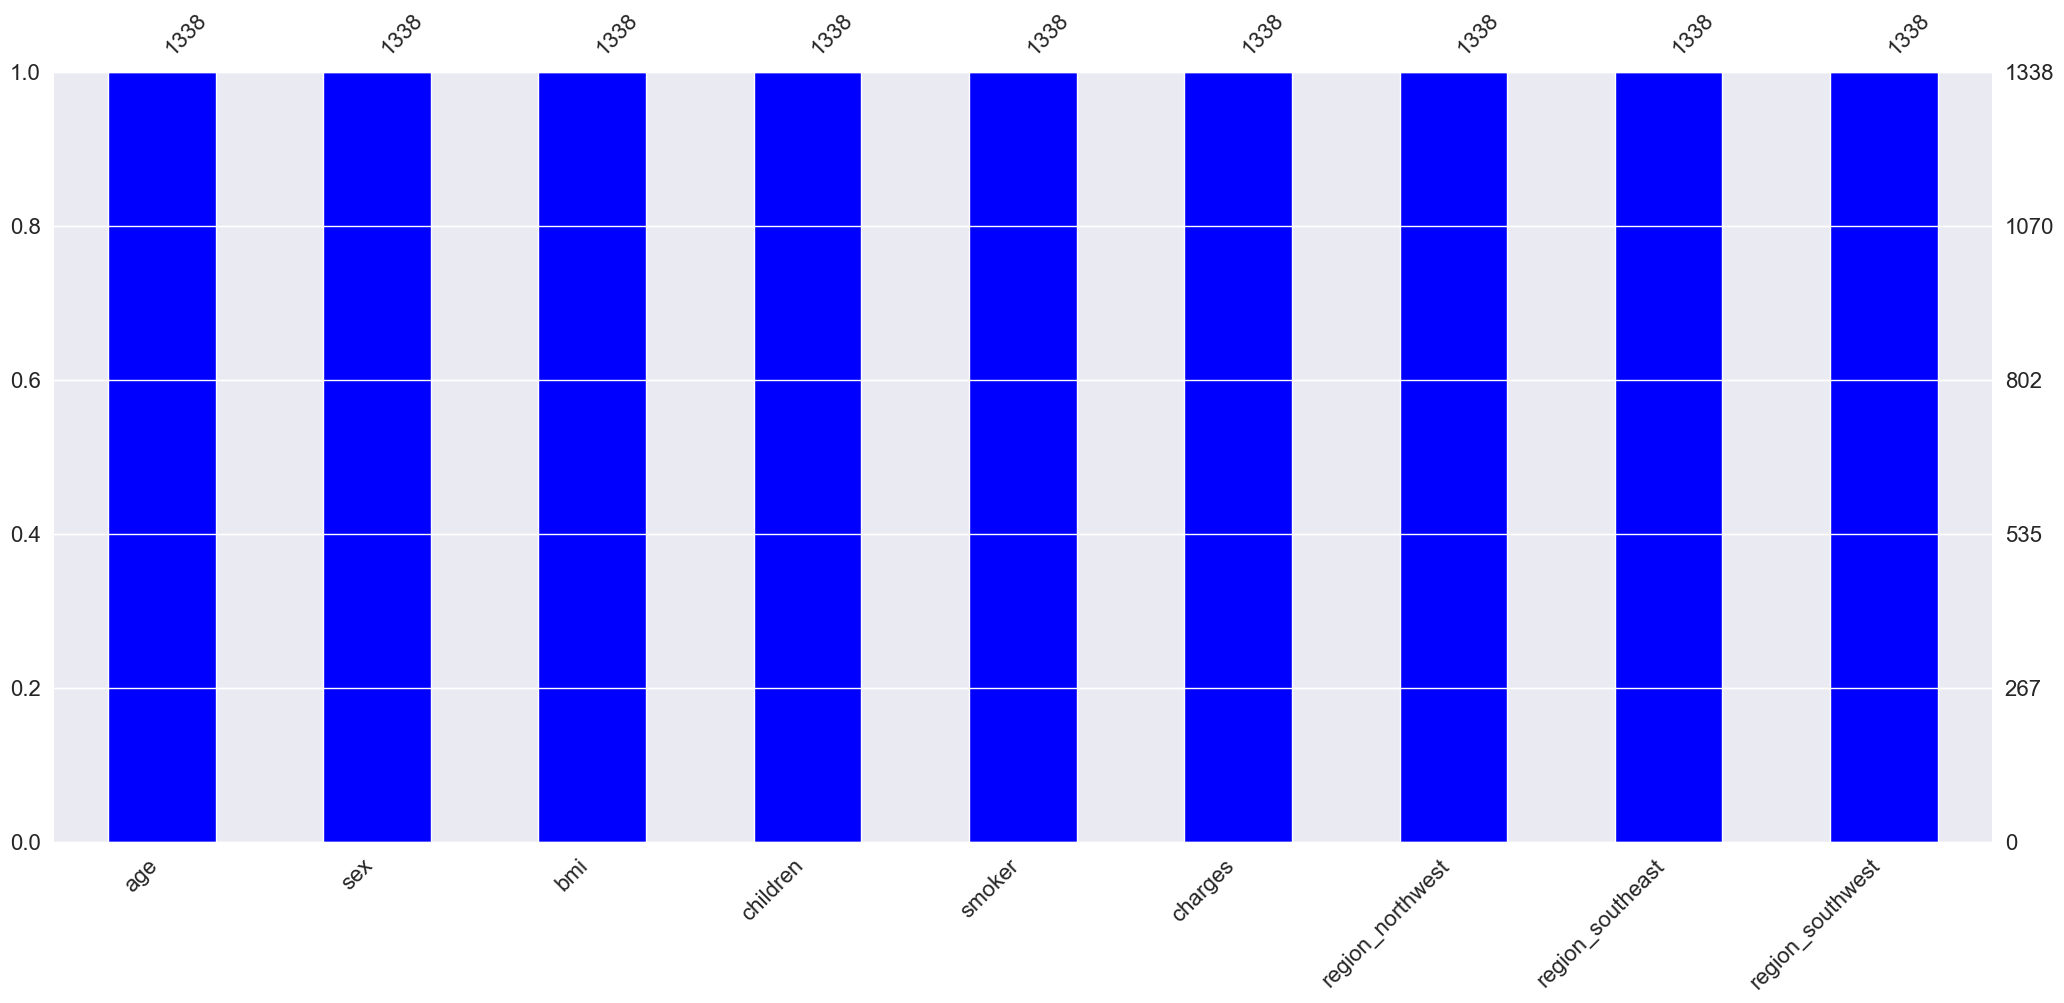

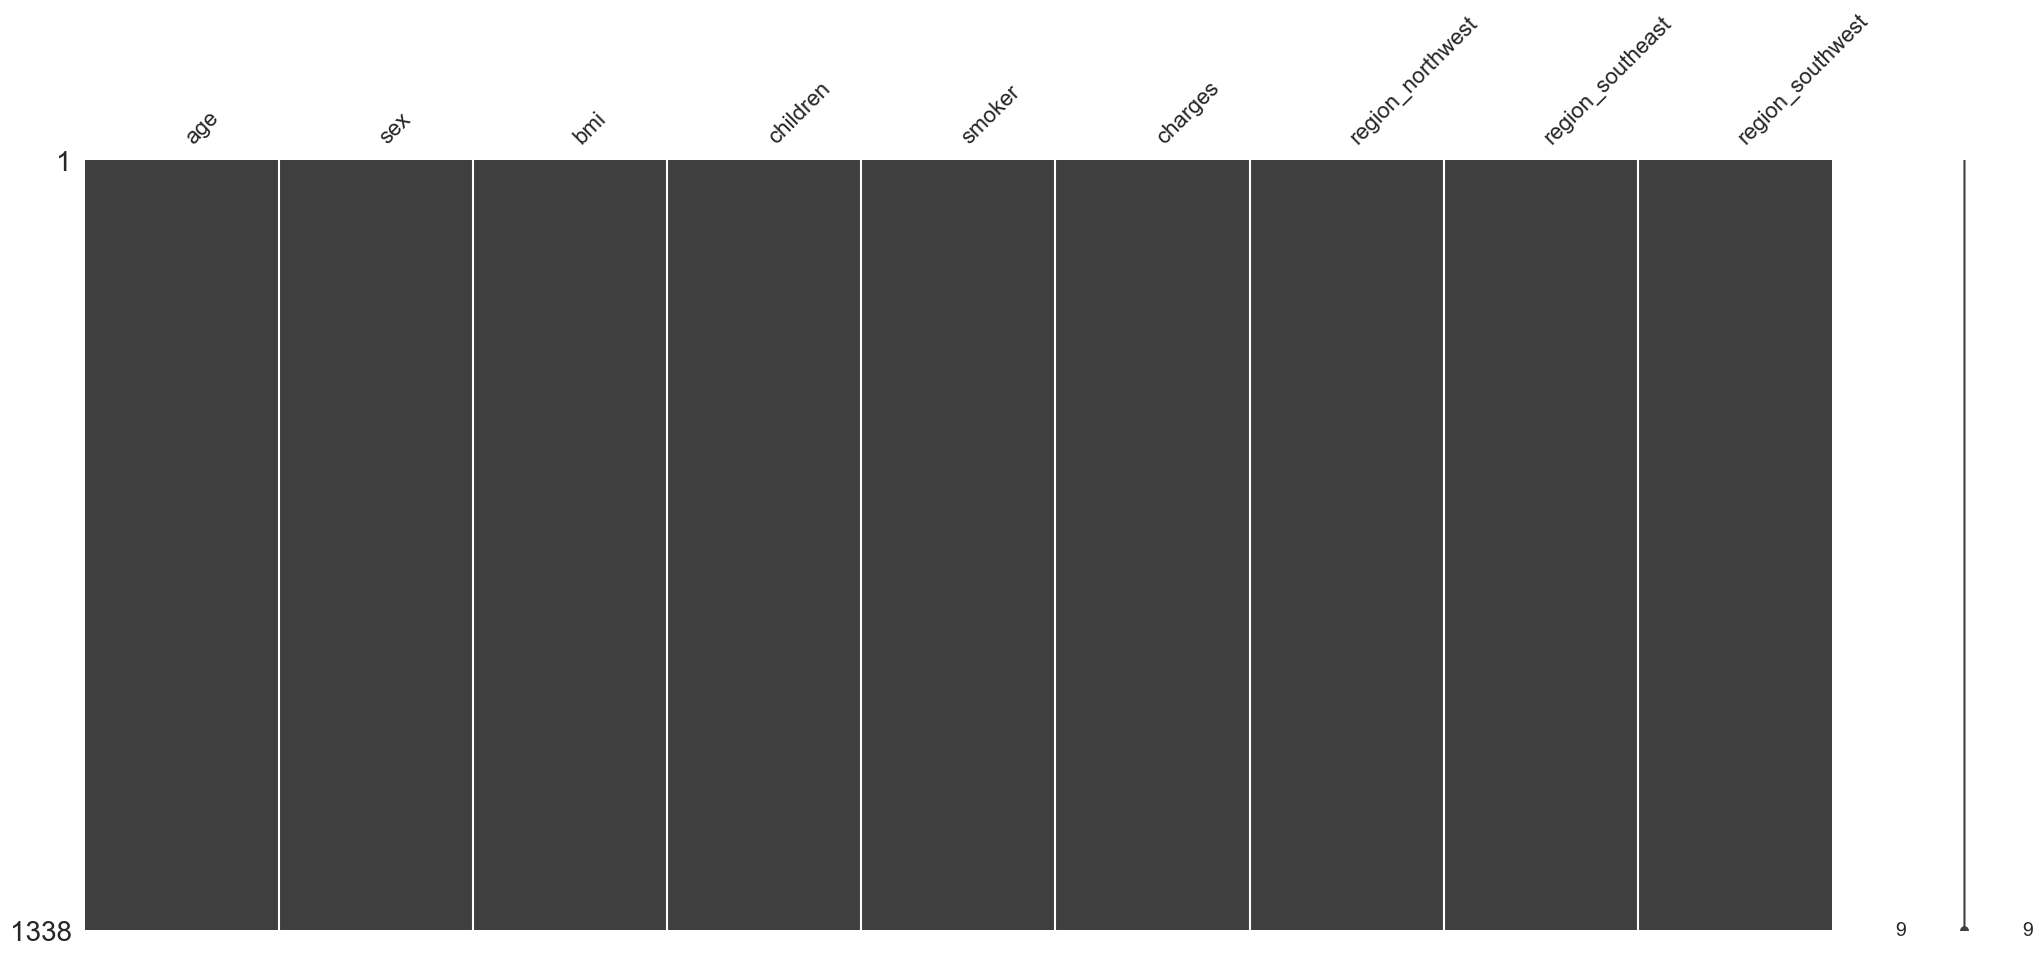

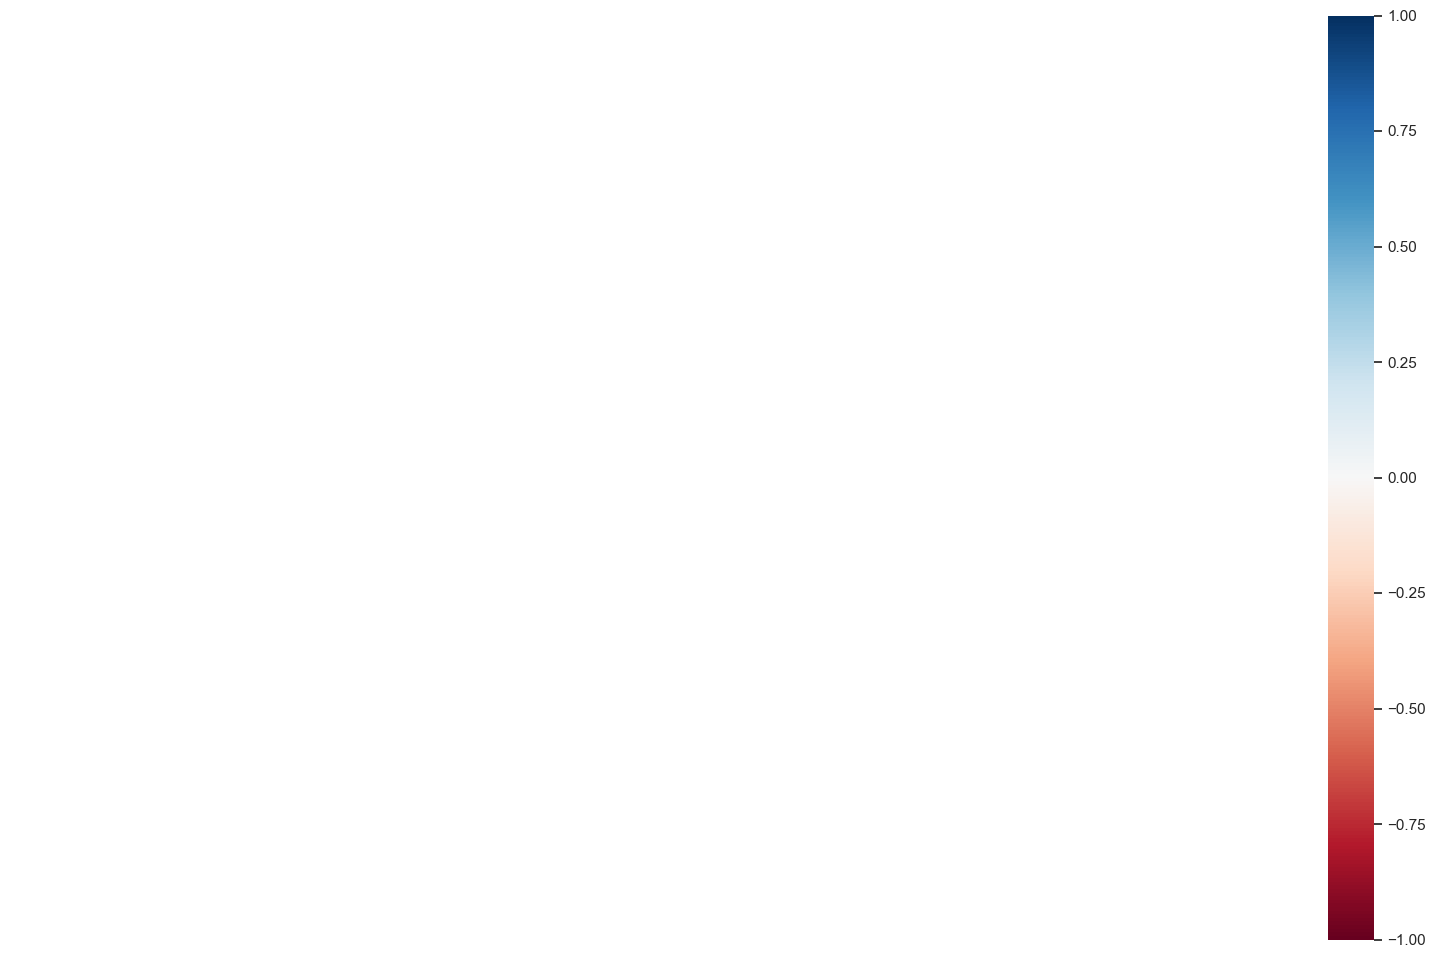

In [298]:
msno.bar(medical,color="blue")
msno.matrix(medical)
msno.heatmap(medical)
plt.show()

## Feature Co-Relation

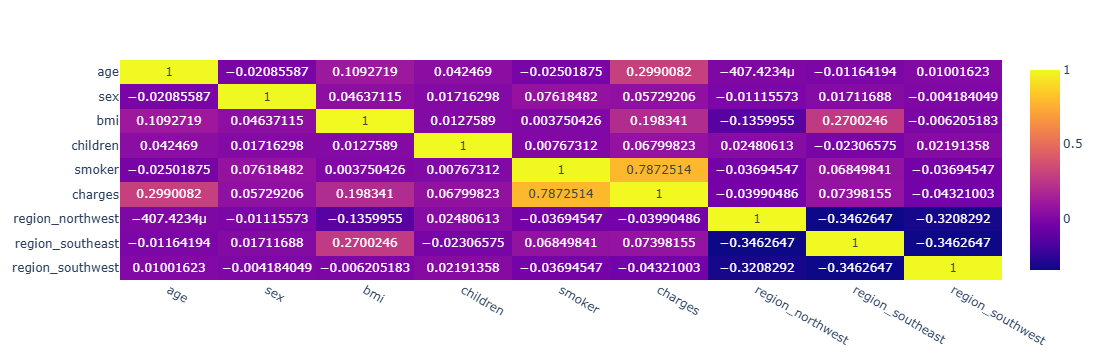

In [299]:
import plotly.express as px
fig = px.imshow(medical.corr(),text_auto=True,aspect="auto")
fig.show()

In [300]:
round(medical.corr(),3)

,age,sex,bmi,children,smoker,charges,region_northwest,region_southeast,region_southwest
age,1.000,-0.021,0.109,0.042,-0.025,0.299,-0.000,-0.012,0.010
sex,-0.021,1.000,0.046,0.017,0.076,0.057,-0.011,0.017,-0.004
bmi,0.109,0.046,1.000,0.013,0.004,0.198,-0.136,0.270,-0.006
children,0.042,0.017,0.013,1.000,0.008,0.068,0.025,-0.023,0.022
smoker,-0.025,0.076,0.004,0.008,1.000,0.787,-0.037,0.068,-0.037
charges,0.299,0.057,0.198,0.068,0.787,1.000,-0.040,0.074,-0.043
region_northwest,-0.000,-0.011,-0.136,0.025,-0.037,-0.040,1.000,-0.346,-0.321
region_southeast,-0.012,0.017,0.270,-0.023,0.068,0.074,-0.346,1.000,-0.346
region_southwest,0.010,-0.004,-0.006,0.022,-0.037,-0.043,-0.321,-0.346,1.000


In [301]:
medical.skew()

age                 0.055673
sex                -0.020951
bmi                 0.284047
children            0.938380
smoker              1.464766
charges             1.515880
region_northwest    1.200409
region_southeast    1.025621
region_southwest    1.200409
dtype: float64

In [302]:
medical.describe()

,age,sex,bmi,children,smoker,charges,region_northwest,region_southeast,region_southwest
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,0.505232,30.663397,1.094918,0.204783,13270.422265,0.242900,0.272048,0.242900
std,14.049960,0.500160,6.098187,1.205493,0.403694,12110.011237,0.428995,0.445181,0.428995
min,18.000000,0.000000,15.960000,0.000000,0.000000,1121.873900,0.000000,0.000000,0.000000
25%,27.000000,0.000000,26.296250,0.000000,0.000000,4740.287150,0.000000,0.000000,0.000000
50%,39.000000,1.000000,30.400000,1.000000,0.000000,9382.033000,0.000000,0.000000,0.000000
75%,51.000000,1.000000,34.693750,2.000000,0.000000,16639.912515,0.000000,1.000000,0.000000
max,64.000000,1.000000,53.130000,5.000000,1.000000,63770.428010,1.000000,1.000000,1.000000


## 3D Plots / Multiple Axes (Visual Insight)

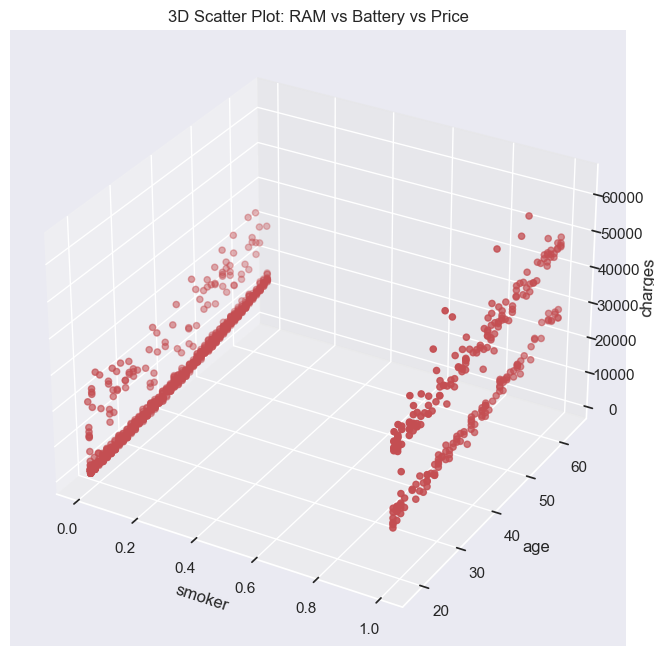

In [303]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(medical['smoker'], medical['age'], medical['charges'], c='r', marker='o')
ax.set_xlabel('smoker')
ax.set_ylabel('age')
ax.set_zlabel('charges')
plt.title("3D Scatter Plot: RAM vs Battery vs Price")
plt.show()

## Pairplot on raw Data(Correlation Visualization)

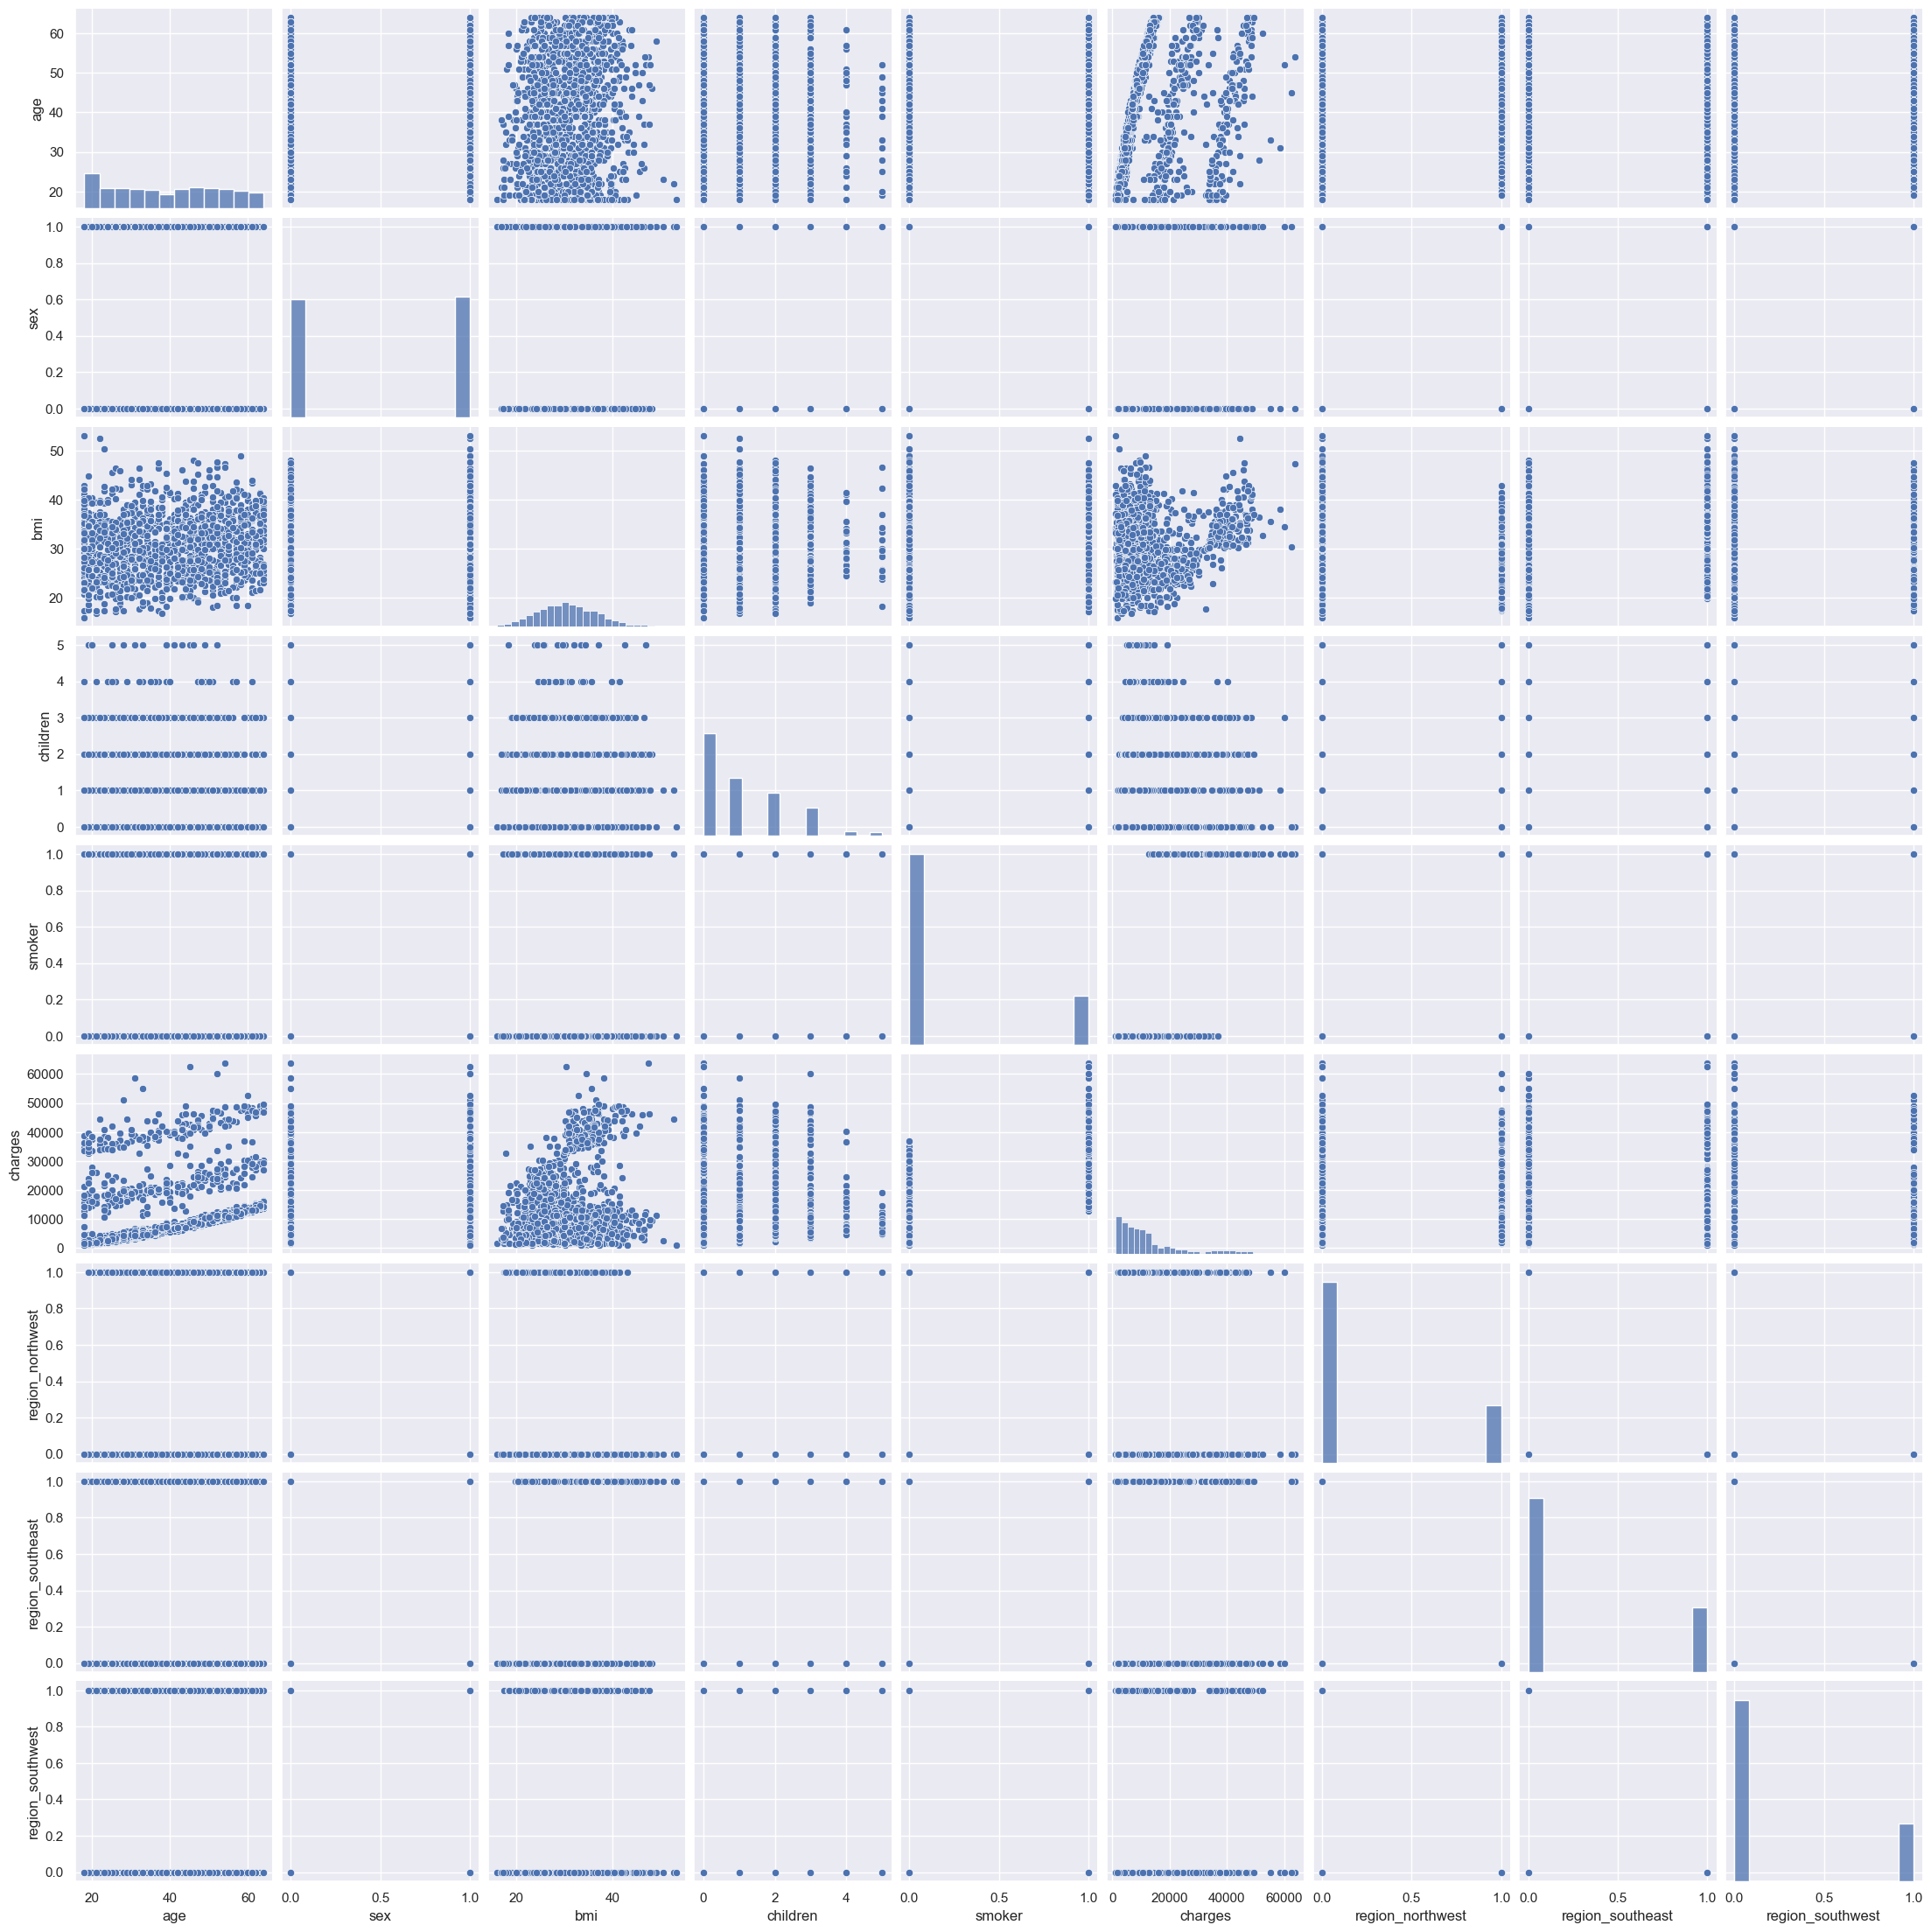

In [304]:
selected_cols = medical.columns # choose relevant features
sns.pairplot(medical[selected_cols])
plt.show()

## MultiCollinearity Detection

In [305]:
def multicolinearity(medical):
    X = add_constant(medical)    #This is done because many statistical models require an intercept term.
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    # Drop  column it’s not an actual feature — it's just there for model fitting.
    vif_data = vif_data[vif_data["Feature"] != "const"]
    
    # Add interpretation column
    def interpret_vif(vif):
        if vif < 1.5:
            return "Low"
        elif vif < 5:
            return "Moderate"
        else:
            return "High"
    
    vif_data["Multicollinearity Level"] = vif_data["VIF"].apply(interpret_vif)
    return vif_data

print("Data:")
display(multicolinearity(medical))

Data:


,Feature,VIF,Multicollinearity Level
1,age,1.373348,Low
2,sex,1.009018,Low
3,bmi,1.223757,Low
4,children,1.013005,Low
5,smoker,3.549468,Moderate
6,charges,4.014662,Moderate
7,region_northwest,1.519451,Moderate
8,region_southeast,1.658042,Moderate
9,region_southwest,1.534055,Moderate


In [306]:
medical.corr()

,age,sex,bmi,children,smoker,charges,region_northwest,region_southeast,region_southwest
age,1.000000,-0.020856,0.109272,0.042469,-0.025019,0.299008,-0.000407,-0.011642,0.010016
sex,-0.020856,1.000000,0.046371,0.017163,0.076185,0.057292,-0.011156,0.017117,-0.004184
bmi,0.109272,0.046371,1.000000,0.012759,0.003750,0.198341,-0.135996,0.270025,-0.006205
children,0.042469,0.017163,0.012759,1.000000,0.007673,0.067998,0.024806,-0.023066,0.021914
smoker,-0.025019,0.076185,0.003750,0.007673,1.000000,0.787251,-0.036945,0.068498,-0.036945
charges,0.299008,0.057292,0.198341,0.067998,0.787251,1.000000,-0.039905,0.073982,-0.043210
region_northwest,-0.000407,-0.011156,-0.135996,0.024806,-0.036945,-0.039905,1.000000,-0.346265,-0.320829
region_southeast,-0.011642,0.017117,0.270025,-0.023066,0.068498,0.073982,-0.346265,1.000000,-0.346265
region_southwest,0.010016,-0.004184,-0.006205,0.021914,-0.036945,-0.043210,-0.320829,-0.346265,1.000000


## PCA Analysis - Select Top-k Components from PCA

In [307]:
medical

,age,sex,bmi,children,smoker,charges,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,0,0,1
1,18,1,33.770,1,0,1725.55230,0,1,0
2,28,1,33.000,3,0,4449.46200,0,1,0
3,33,1,22.705,0,0,21984.47061,1,0,0
4,32,1,28.880,0,0,3866.85520,1,0,0
...,...,...,...,...,...,...,...,...,...
1333,50,1,30.970,3,0,10600.54830,1,0,0
1334,18,0,31.920,0,0,2205.98080,0,0,0
1335,18,0,36.850,0,0,1629.83350,0,1,0
1336,21,0,25.800,0,0,2007.94500,0,0,1


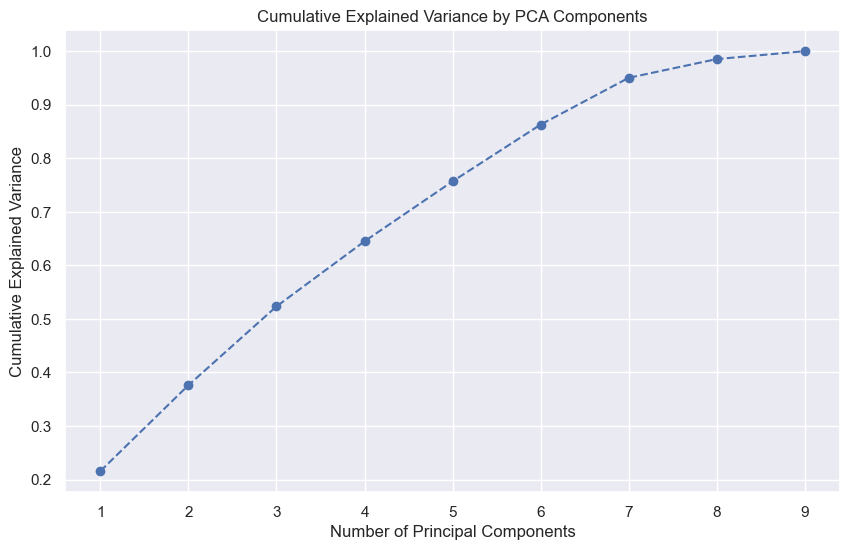

Number of components to retain 90% variance: 7
Original shape: (1338, 9)
Transformed shape: (1338, 9)
Explained Variance Ratio:


,0
0,0.215591
1,0.160487
2,0.147150
3,0.121607
4,0.112009
5,0.106052
6,0.087363
7,0.034987
8,0.014754


array([[ 0.50619297, -0.86869692,  1.71227635, ...,  0.84515916,
         0.40431917, -0.61030049],
       [-0.4497628 ,  2.09701037, -0.79611581, ...,  0.18862403,
         0.2574983 ,  0.01999923],
       [-0.08878075,  1.75571836, -0.62587036, ..., -0.27282518,
         0.27121682, -0.03513535],
       ...,
       [-0.57107433,  2.39649589, -0.84042466, ...,  0.97343052,
         0.20006105, -0.05174664],
       [-1.79828684,  0.01808811,  1.62383758, ...,  0.38475196,
         0.36934871,  0.14457593],
       [ 1.74407309, -2.28477325, -1.02227688, ...,  0.04981661,
         0.43503985, -0.69132219]])

In [308]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(medical)

n_components=medical.shape[1]
pca = PCA(n_components)
X_reduced = pca.fit_transform(X_scaled)

explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

pca_components = pd.DataFrame(pca.components_, columns=medical.columns)
#print(pca_components.head())

n_components = next(i for i, total_var in enumerate(cumulative_variance) if total_var >= 0.90) + 1
print(f"Number of components to retain 90% variance: {n_components}")

print("Original shape:", X_scaled.shape)
print("Transformed shape:", X_reduced.shape)

print("Explained Variance Ratio:") 
display(pd.DataFrame(pca.explained_variance_ratio_))
display(X_reduced)

# Skew Catagory

In [309]:
def categorize_skew(value):
    """Categorize skewness based on its magnitude."""
    if abs(value) > 1:
        return 'Highly Skewed'
    elif abs(value) > 0.5:
        return 'Moderately Skewed'
    else:
        return 'Approximately Symmetric'

def skew_summary_table(df):
    
    numeric_df = df.select_dtypes(include=['number'])  # Only numeric columns
    skew_values = numeric_df.skew()                    # Compute skewness
    skew_categories = skew_values.apply(categorize_skew)

    summary_df = pd.DataFrame({
        'Skewness': skew_values,
        'Category': skew_categories
    }).sort_values(by='Skewness', ascending=False)

    return summary_df
skew_summary_table(medical)

,Skewness,Category
charges,1.515880,Highly Skewed
smoker,1.464766,Highly Skewed
region_northwest,1.200409,Highly Skewed
region_southwest,1.200409,Highly Skewed
region_southeast,1.025621,Highly Skewed
children,0.938380,Moderately Skewed
bmi,0.284047,Approximately Symmetric
age,0.055673,Approximately Symmetric
sex,-0.020951,Approximately Symmetric


## Outlier Detection

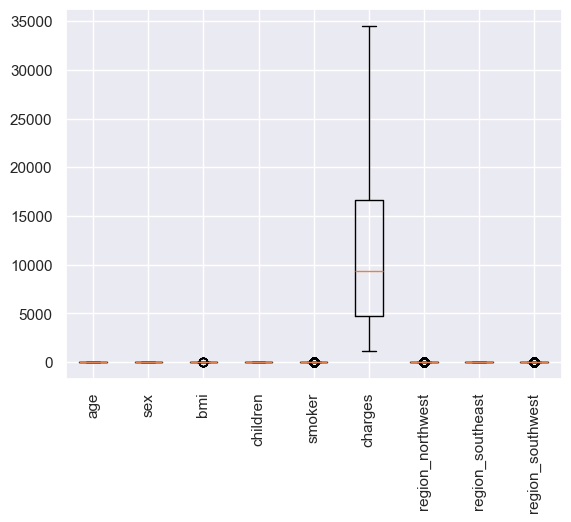

In [319]:
plt.boxplot(medical,labels=medical.columns )
plt.xticks(rotation=90)
plt.show()

## Skew, Spread and variance of each variable

In [112]:
medical.skew()

age                 0.055673
sex                -0.020951
bmi                 0.284047
children            0.938380
smoker              1.464766
charges             1.515880
region_northwest    1.200409
region_southeast    1.025621
region_southwest    1.200409
dtype: float64

In [113]:
def price_vs_var(col):
    #plt.figure(figsize=(10,6))
    sns.histplot(medical[col],kde=True,color='blue')
    #plt.show() 

cols_to_use = [col for col in medical.columns if (col !="product_id") ]
for col in cols_to_use:
    price_vs_var(col)

# Part I - Outlier Treatment for each variable by IQR and Other method

In [114]:
medical.shape

(1338, 9)

In [312]:
def iqr(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr_value = q3 - q1
    lower_bound = q1 - (1.5 * iqr_value)
    upper_bound = q3 + (1.5 * iqr_value)

    outliers = (df[col] < lower_bound) | (df[col] > upper_bound)
    num_outliers = outliers.sum()
    total = df.shape[0]
    outlier_percent = (num_outliers / total) * 100

    # Apply treatment based on rules
    if outlier_percent <= 1:
        treatment = "No Treatment"
    elif outlier_percent <= 10:
        treatment = "Mean Imputation"
        mean_val = df.loc[~outliers, col].mean()
        df.loc[outliers, col] = mean_val
    elif outlier_percent <= 20:
        treatment = "Capping"
        df.loc[df[col] < lower_bound, col] = lower_bound
        df.loc[df[col] > upper_bound, col] = upper_bound
    elif outlier_percent >= 20:
        treatment = "Flagged for Row Removal,transformation, or binning"
    return num_outliers, outlier_percent, treatment, df

In [313]:
def outlier(df):
    #data = df.copy()
    
    cols_to_use = [col for col in df.columns if pd.api.types.is_numeric_dtype(df[col])]
    outlier_summary = []
    
    for col in cols_to_use:
        num_outliers, percent, treatment, df_iqr = iqr(df, col)
        outlier_summary.append({
            "Column": col,
            "Num Outliers": num_outliers,
            "Outlier %": round(percent, 2),
            "Treatment Applied": treatment
        })
    outlier_table = pd.DataFrame(outlier_summary)
    display(outlier_table)
    return df_iqr

In [314]:
medical_iqr = outlier(medical)
medical_iqr

,Column,Num Outliers,Outlier %,Treatment Applied
0,age,0,0.00,No Treatment
1,sex,0,0.00,No Treatment
2,bmi,9,0.67,No Treatment
3,children,0,0.00,No Treatment
4,smoker,274,20.48,"Flagged for Row Removal,transformation, or bin..."
5,charges,139,10.39,Capping
6,region_northwest,325,24.29,"Flagged for Row Removal,transformation, or bin..."
7,region_southeast,0,0.00,No Treatment
8,region_southwest,325,24.29,"Flagged for Row Removal,transformation, or bin..."


,age,sex,bmi,children,smoker,charges,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,0,0,1
1,18,1,33.770,1,0,1725.55230,0,1,0
2,28,1,33.000,3,0,4449.46200,0,1,0
3,33,1,22.705,0,0,21984.47061,1,0,0
4,32,1,28.880,0,0,3866.85520,1,0,0
...,...,...,...,...,...,...,...,...,...
1333,50,1,30.970,3,0,10600.54830,1,0,0
1334,18,0,31.920,0,0,2205.98080,0,0,0
1335,18,0,36.850,0,0,1629.83350,0,1,0
1336,21,0,25.800,0,0,2007.94500,0,0,1


#### Outlier % Range	Category	Interpretation
##### 0–1%	None/Negligible	Can be ignored; safe to keep
##### 1–10%	Low	Normal variability; imputation is okay -Mean/Median Imputation
##### 10–20%	Moderate	Needs capping or transformation
##### >20%	High	Strong deviation; risky - Transformation (e.g. log, Yeo-Johnson)
##### >30–40%	Very High	Consider transformation or removal -Consider row removal or binning

In [315]:
medical.shape

(1338, 9)

In [316]:
medical_iqr.shape

(1338, 9)

## Before Outlier Treatment

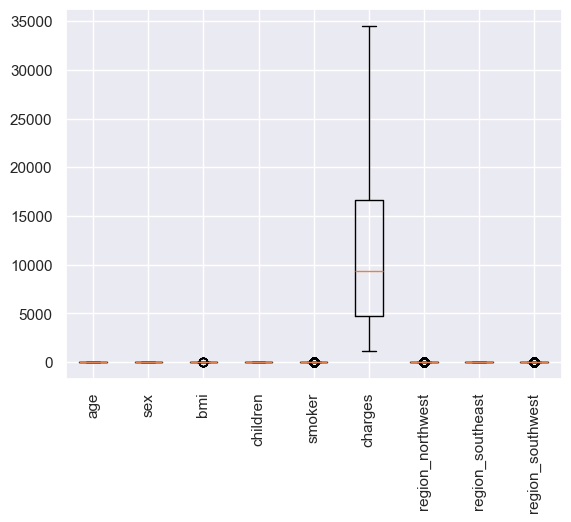

In [317]:
plt.boxplot(medical,labels=medical.columns )
plt.xticks(rotation=90)
plt.show()

## After Outlier Treatment

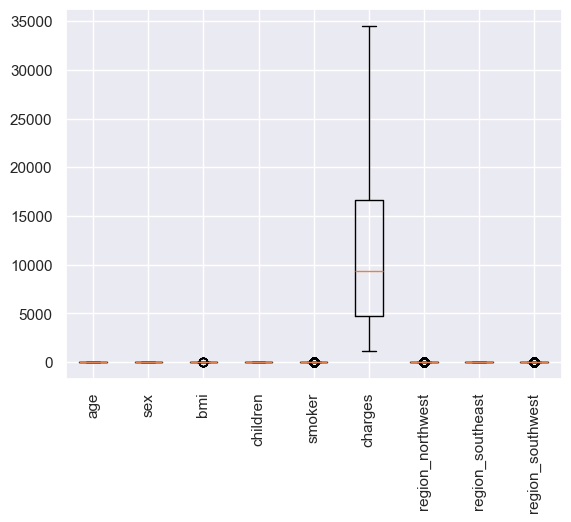

In [174]:
plt.boxplot(medical_iqr,labels=medical_iqr.columns )
plt.xticks(rotation=90)
plt.show()

## Skewness Detection and Transformation

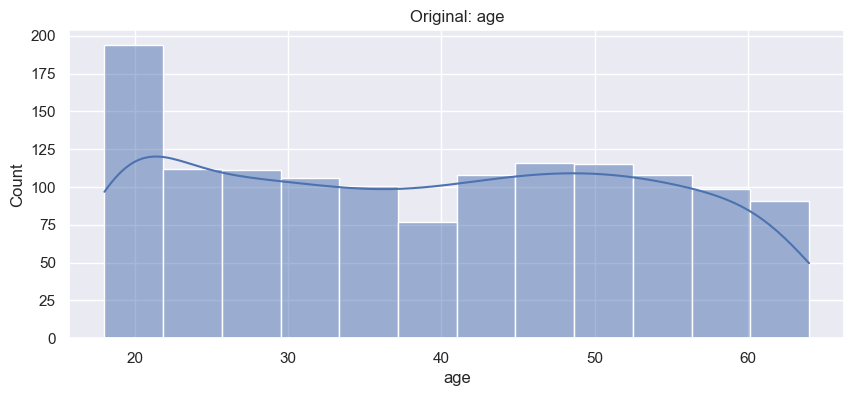

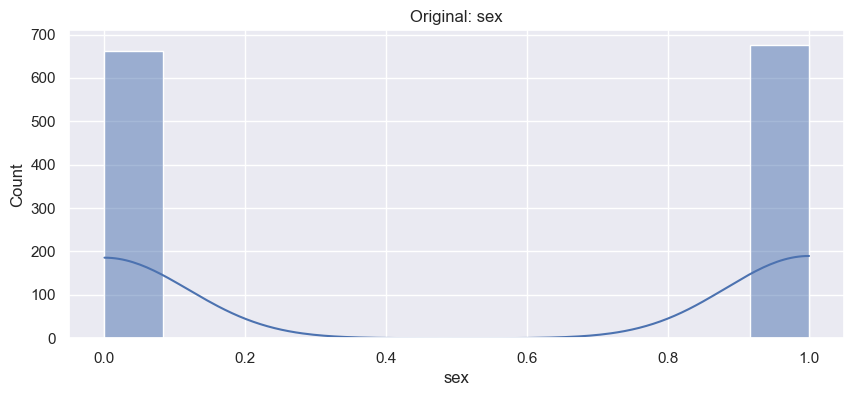

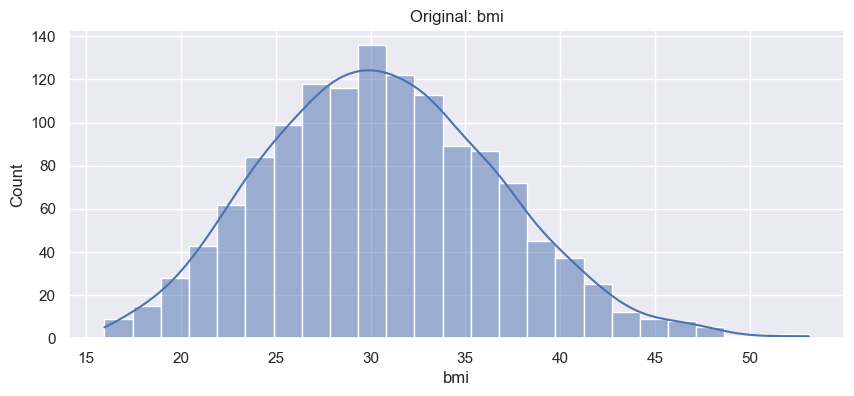

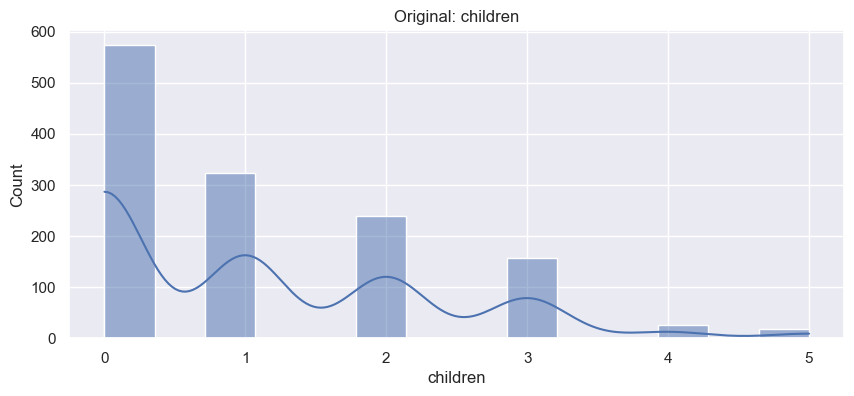

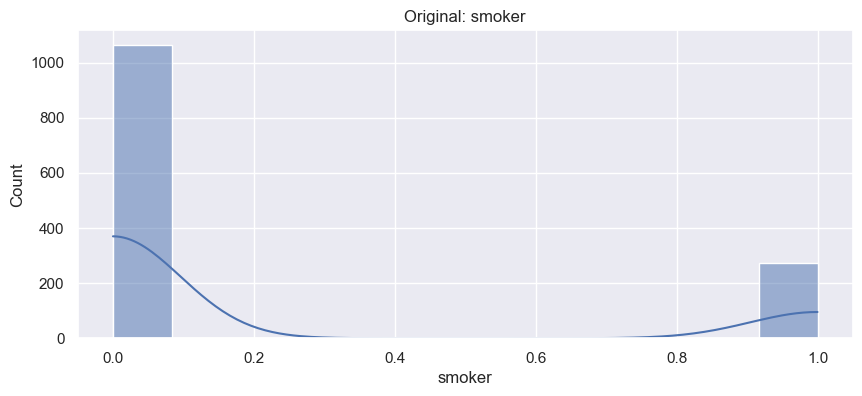

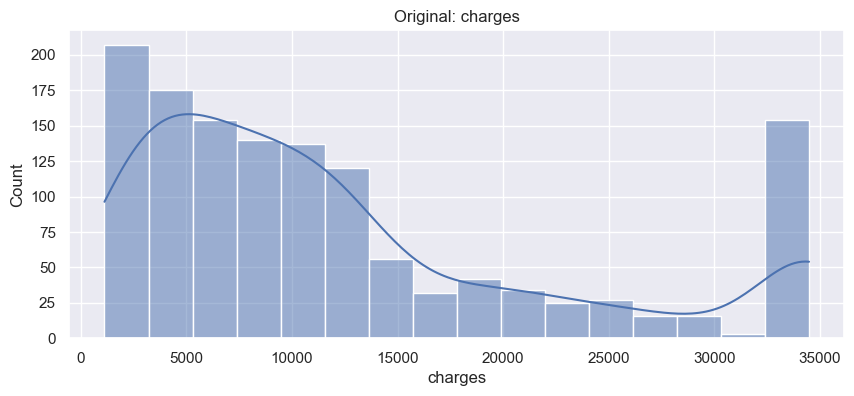

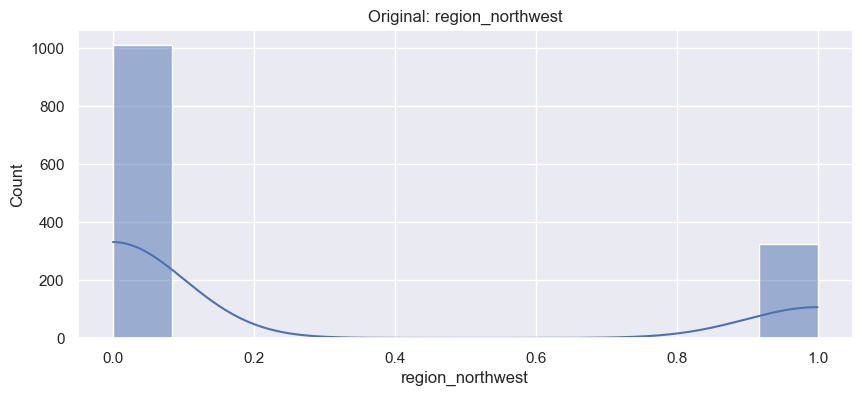

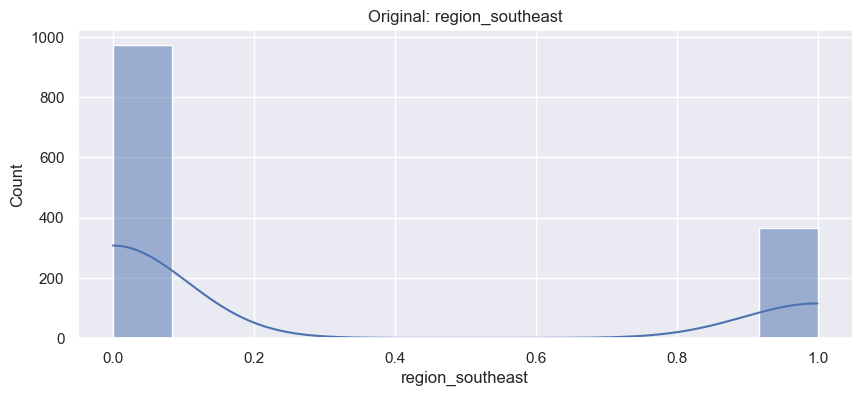

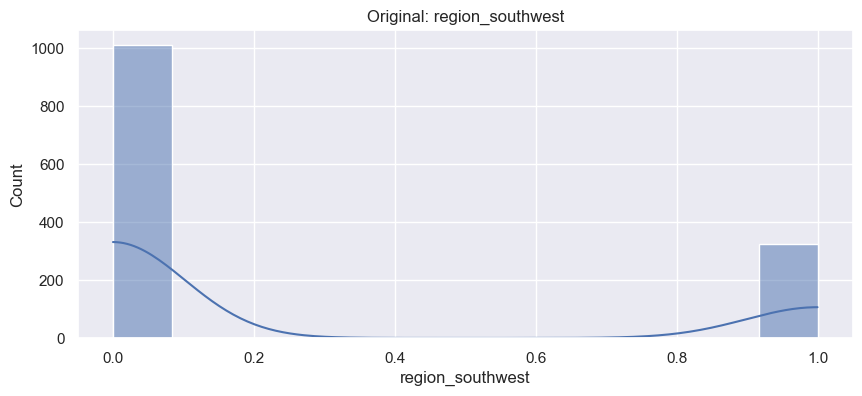

In [124]:
for col in medical.columns:
    plt.figure(figsize=(10,4))
    sns.histplot(medical[col], kde=True)
    plt.title(f"Original: {col}")
    plt.show()

In [71]:
medical.skew()

age                 0.055673
sex                -0.020951
bmi                 0.284047
children            0.938380
smoker              1.464766
charges             1.515880
region_northwest    1.200409
region_southeast    1.025621
region_southwest    1.200409
dtype: float64

### Z Score Method

In [157]:
def zscore(df,col):
    df[col] = (df[col]  - df[col].mean() ) / df[col].std()
    df.head()
    return df    
   
medical_zscore = medical.copy()
cols_to_use = [col for col in medical_zscore.columns]

for col in cols_to_use:
    #print(col)
    medical_zscore = zscore(medical_zscore, col)

medical_zscore.skew()

age                 0.055673
sex                -0.020951
bmi                 0.284047
children            0.938380
smoker              1.464766
charges             1.083730
region_northwest    1.200409
region_southeast    1.025621
region_southwest    1.200409
dtype: float64

In [158]:
combined = pd.concat([medical.skew(), medical_zscore.skew()], axis=1)
combined.columns = ['medical', 'ZScore_medical']
combined

,medical,ZScore_medical
age,0.055673,0.055673
sex,-0.020951,-0.020951
bmi,0.284047,0.284047
children,0.938380,0.938380
smoker,1.464766,1.464766
charges,1.083730,1.083730
region_northwest,1.200409,1.200409
region_southeast,1.025621,1.025621
region_southwest,1.200409,1.200409


# Part II - Various Transformations Method to Address skewness

## Transformations on Data

In [159]:
# Tranaform nction
y = medical['charges']
X = medical.drop(columns='charges')

# Step 1: Encode binary categorical columns using LabelEncoder
X['sex'] = LabelEncoder().fit_transform(X['sex'])        # Male=1, Female=0
X['smoker'] = LabelEncoder().fit_transform(X['smoker'])  # Yes=1, No=0

# Step 2: Define transformations
numeric_cols = ['age', 'bmi', 'children']
onehot_cols = ['region']

# Create column transformer
preprocessor = ColumnTransformer(transformers=[
    ('yeojohnson', PowerTransformer(method='yeo-johnson'), ['bmi']),        # Transform skewed
    ('scaler', StandardScaler(), ['age', 'children']),                      # Scale other numeric
    ('onehot', OneHotEncoder(drop='first'), onehot_cols)                   # One-hot encode region
], remainder='passthrough')  # Keep label-encoded 'sex' and 'smoker'

# Step 3: Transform the target using log1p
y_transformed = np.log1p(y)

# Step 4: Apply transformations to features
X_transformed = preprocessor.fit_transform(X)
#pd.DataFrame(X_transformed)

NameError: name 'ColumnTransformer' is not defined

In [189]:
for col in medical.columns:
    if (col == "region_northwest") | (col == "region_southeast") | (col == "region_southwest") | (col == "smoker") | (col == "sex"):
        continue
    else:
        print(col)

age
bmi
children
charges


In [320]:
def best_skew_transformation(df):
    df_transformed = df.copy()
    results = []

    # Store transformation metadata per column like lambda Values, Colmn name and tranaformation type.
    transform_meta = {}  

    numeric_cols = df.select_dtypes(include=np.number).columns
    print(numeric_cols)

    for col in numeric_cols:
        
        #if (col == "region_northwest") | (col == "region_southeast") | (col == "region_southwest") | (col == "smoker") | (col == "sex"):              
       #     continue                                    
        col_data = df[col].dropna()

        if col_data.nunique() <= 1:
            continue

        original_skew = skew(col_data)
        transform_results = {"Column": col, "Original Skew": round(original_skew, 4)}

        best_transform = None
        best_skew = abs(original_skew)
        best_lambda = None  # Store if Box-Cox or Yeo-Johnson is chosen
        print("Processing",col)
        # Log
        if (col_data > 0).all():
            log_data = np.log1p(col_data)
            log_skew = abs(skew(log_data))
            transform_results["Log Skew"] = round(log_skew, 4)
            if log_skew < best_skew:
                best_transform = ("log1p", np.log1p)
                best_skew = log_skew
        else:
            transform_results["Log Skew"] = np.nan

        # Sqrt
        if (col_data >= 0).all():
            sqrt_data = np.sqrt(col_data)
            sqrt_skew = abs(skew(sqrt_data))
            transform_results["Sqrt Skew"] = round(sqrt_skew, 4)
            if sqrt_skew < best_skew:
                best_transform = ("sqrt", np.sqrt)
                best_skew = sqrt_skew
        else:
            transform_results["Sqrt Skew"] = np.nan

        # Box-Cox
        if (col_data > 0).all():
            try:
                boxcox_data, lam_boxcox = boxcox(col_data)
                boxcox_skew = abs(skew(boxcox_data))
                transform_results["Box-Cox Skew"] = round(boxcox_skew, 4)
                if boxcox_skew < best_skew:
                    best_transform = ("boxcox", lambda x: boxcox(x)[0])
                    best_skew = boxcox_skew
                    best_lambda = lam_boxcox
            except:
                transform_results["Box-Cox Skew"] = np.nan
        else:
            transform_results["Box-Cox Skew"] = np.nan

        # Yeo-Johnson
        try:
            yeoj_data, lam_yeo = yeojohnson(col_data)
            yeoj_skew = abs(skew(yeoj_data))
            transform_results["Yeo-Johnson Skew"] = round(yeoj_skew, 4)
            if yeoj_skew < best_skew:
                best_transform = ("yeojohnson", lambda x: yeojohnson(x)[0])
                best_skew = yeoj_skew
                best_lambda = lam_yeo
        except:
            transform_results["Yeo-Johnson Skew"] = np.nan

        # Apply and record best transformation
        if best_transform:
            method_name = best_transform[0]
            transform_results["Best Transformation"] = method_name
            df_transformed[col] = best_transform[1](df[col])
            transform_meta[col] = {
                "method": method_name,
                "lambda": best_lambda  # may be None for log/sqrt
            }
        else:
            transform_results["Best Transformation"] = "Original"
            transform_meta[col] = {"method": "original", "lambda": None}

        results.append(transform_results)

    summary_df = pd.DataFrame(results)
    return df_transformed, summary_df, transform_meta

In [321]:
transformed_medical, skew_summary, transform_metadata = best_skew_transformation(medical.copy())
skew_summary

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'charges',
       'region_northwest', 'region_southeast', 'region_southwest'],
      dtype='object')
Processing age
Processing sex
Processing bmi
Processing children
Processing smoker
Processing charges
Processing region_northwest
Processing region_southeast
Processing region_southwest


,Column,Original Skew,Log Skew,Sqrt Skew,Box-Cox Skew,Yeo-Johnson Skew,Best Transformation
0,age,0.0556,0.3607,0.1565,0.1036,0.1001,Original
1,sex,-0.0209,NaN,0.0209,NaN,0.0209,yeojohnson
2,bmi,0.2837,0.2380,0.0141,0.0071,0.0066,yeojohnson
3,children,0.9373,NaN,0.1162,NaN,0.1051,yeojohnson
4,smoker,1.4631,NaN,1.4631,NaN,1.4631,yeojohnson
5,charges,1.0825,0.2232,0.5253,0.0289,0.0288,yeojohnson
6,region_northwest,1.1991,NaN,1.1991,NaN,1.1991,Original
7,region_southeast,1.0245,NaN,1.0245,NaN,1.0245,Original
8,region_southwest,1.1991,NaN,1.1991,NaN,1.1991,Original


In [322]:
transformed_medical.skew()

age                 0.055673
sex                -0.020951
bmi                -0.006617
children            0.105254
smoker              1.464766
charges            -0.028875
region_northwest    1.200409
region_southeast    1.025621
region_southwest    1.200409
dtype: float64

In [324]:
transform_metadata

{'age': {'method': 'original', 'lambda': None},
 'sex': {'method': 'yeojohnson', 'lambda': 0.09057868468195558},
 'bmi': {'method': 'yeojohnson', 'lambda': 0.4431722959598427},
 'children': {'method': 'yeojohnson', 'lambda': -0.3662726018627444},
 'smoker': {'method': 'yeojohnson', 'lambda': -6.73295920432821},
 'charges': {'method': 'yeojohnson', 'lambda': 0.12079319380934961},
 'region_northwest': {'method': 'original', 'lambda': None},
 'region_southeast': {'method': 'original', 'lambda': None},
 'region_southwest': {'method': 'original', 'lambda': None}}

In [325]:
medical

,age,sex,bmi,children,smoker,charges,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,0,0,1
1,18,1,33.770,1,0,1725.55230,0,1,0
2,28,1,33.000,3,0,4449.46200,0,1,0
3,33,1,22.705,0,0,21984.47061,1,0,0
4,32,1,28.880,0,0,3866.85520,1,0,0
...,...,...,...,...,...,...,...,...,...
1333,50,1,30.970,3,0,10600.54830,1,0,0
1334,18,0,31.920,0,0,2205.98080,0,0,0
1335,18,0,36.850,0,0,1629.83350,0,1,0
1336,21,0,25.800,0,0,2007.94500,0,0,1


In [326]:
transformed_medical

,age,sex,bmi,children,smoker,charges,region_northwest,region_southeast,region_southwest
0,19,0.000000,7.763290,0.000000,0.147127,18.550961,0,0,1
1,18,0.715369,8.618976,0.612155,0.000000,12.091190,0,1,0
2,28,0.715369,8.511575,1.087056,0.000000,14.559492,0,1,0
3,33,0.715369,6.920914,0.000000,0.000000,19.419998,1,0,0
4,32,0.715369,7.912470,0.000000,0.000000,14.175688,1,0,0
...,...,...,...,...,...,...,...,...,...
1333,50,0.715369,8.221764,1.087056,0.000000,17.084045,1,0,0
1334,18,0.000000,8.358628,0.000000,0.000000,12.704294,0,0,0
1335,18,0.000000,9.035843,0.000000,0.000000,11.951335,0,1,0
1336,21,0.000000,7.433840,0.000000,0.000000,12.467351,0,0,1


## Comparison b/w Transformed and Original Data

In [327]:
skew_summary

,Column,Original Skew,Log Skew,Sqrt Skew,Box-Cox Skew,Yeo-Johnson Skew,Best Transformation
0,age,0.0556,0.3607,0.1565,0.1036,0.1001,Original
1,sex,-0.0209,NaN,0.0209,NaN,0.0209,yeojohnson
2,bmi,0.2837,0.2380,0.0141,0.0071,0.0066,yeojohnson
3,children,0.9373,NaN,0.1162,NaN,0.1051,yeojohnson
4,smoker,1.4631,NaN,1.4631,NaN,1.4631,yeojohnson
5,charges,1.0825,0.2232,0.5253,0.0289,0.0288,yeojohnson
6,region_northwest,1.1991,NaN,1.1991,NaN,1.1991,Original
7,region_southeast,1.0245,NaN,1.0245,NaN,1.0245,Original
8,region_southwest,1.1991,NaN,1.1991,NaN,1.1991,Original


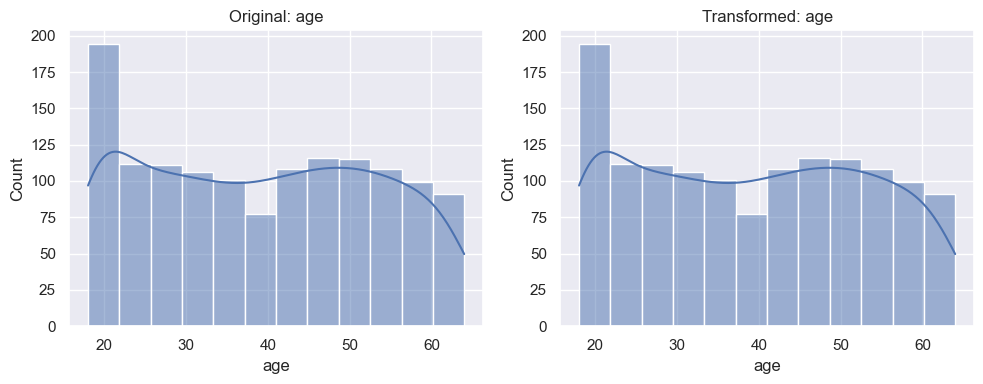

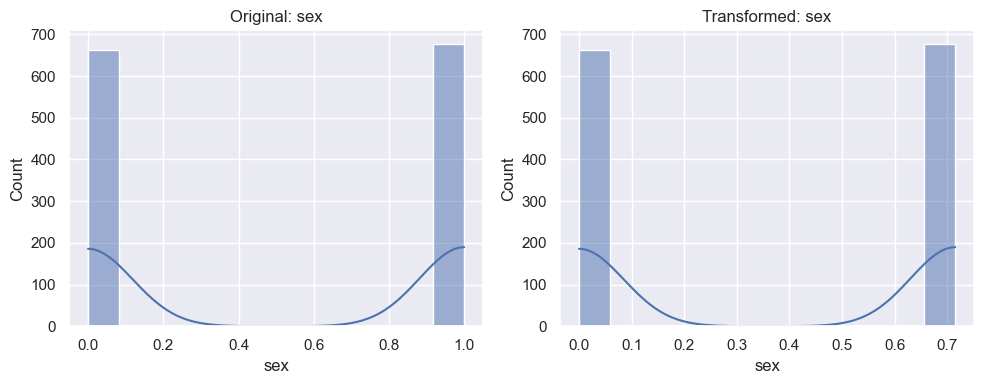

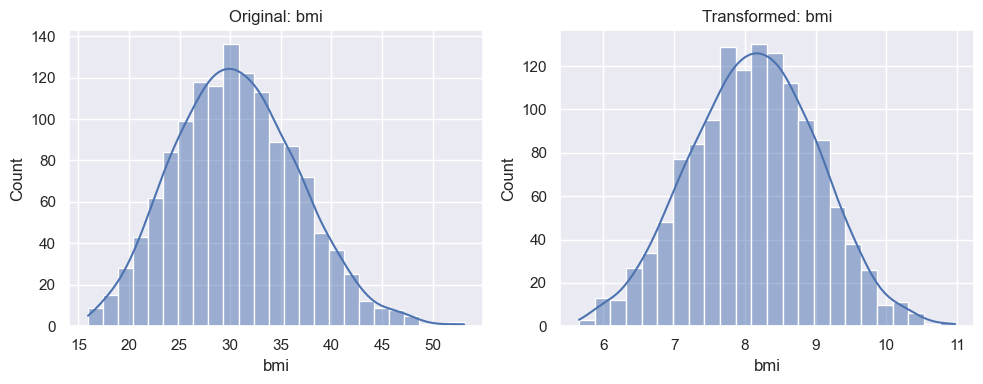

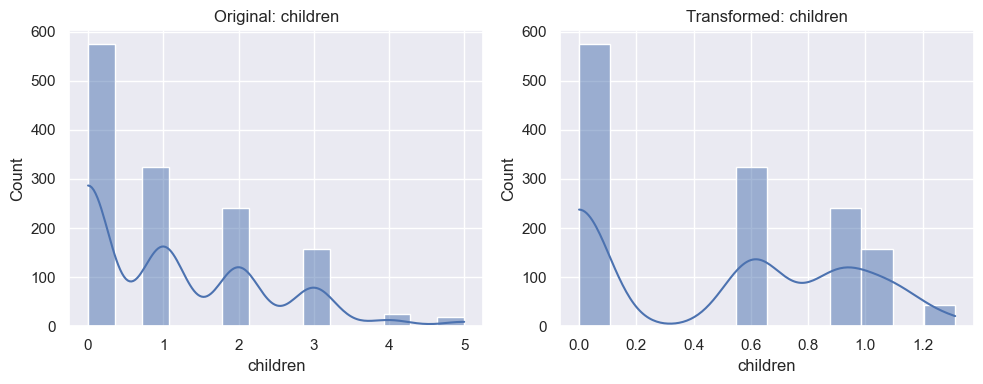

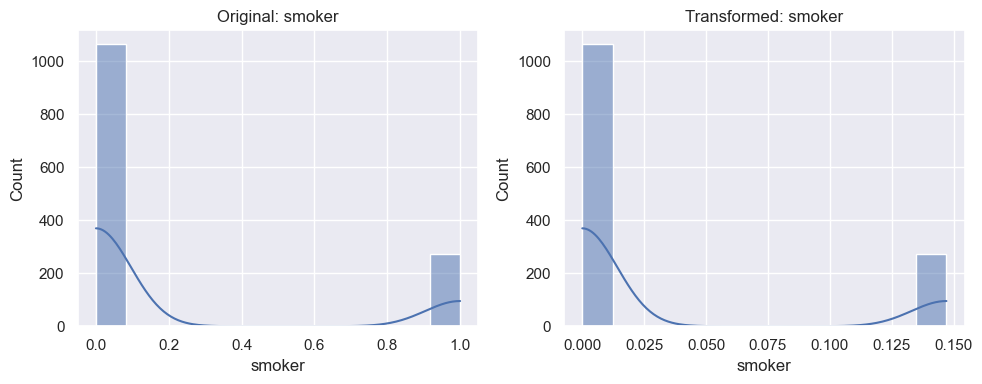

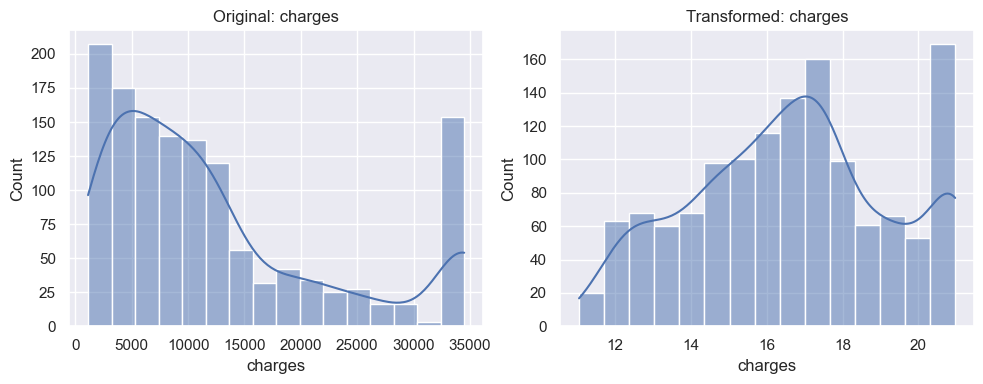

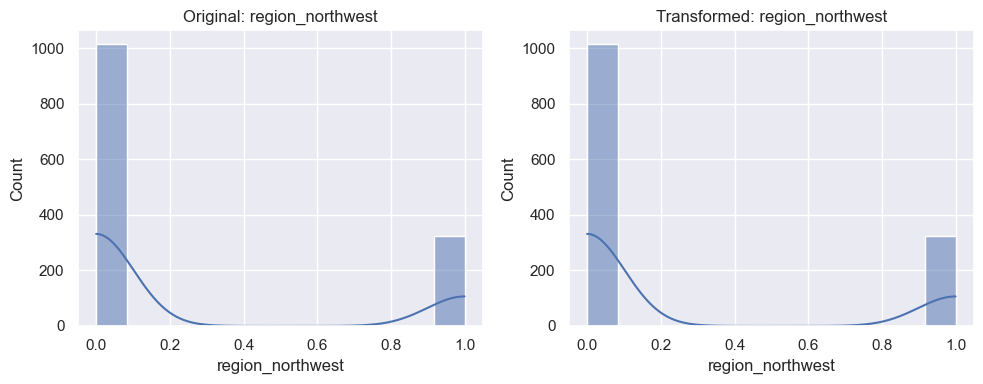

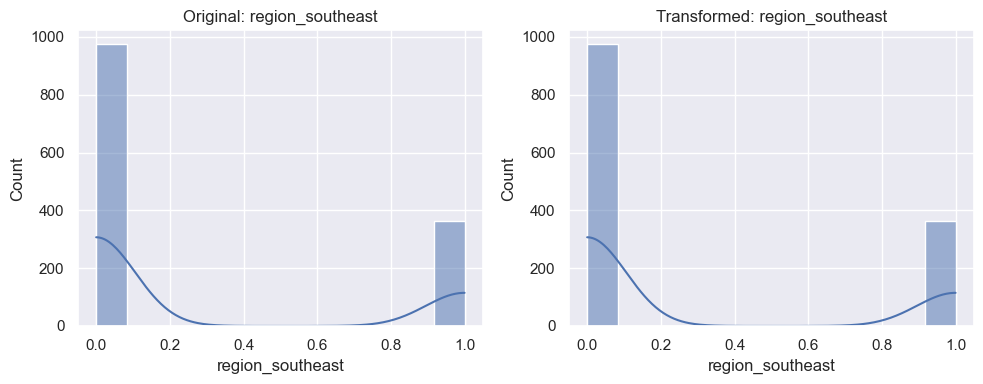

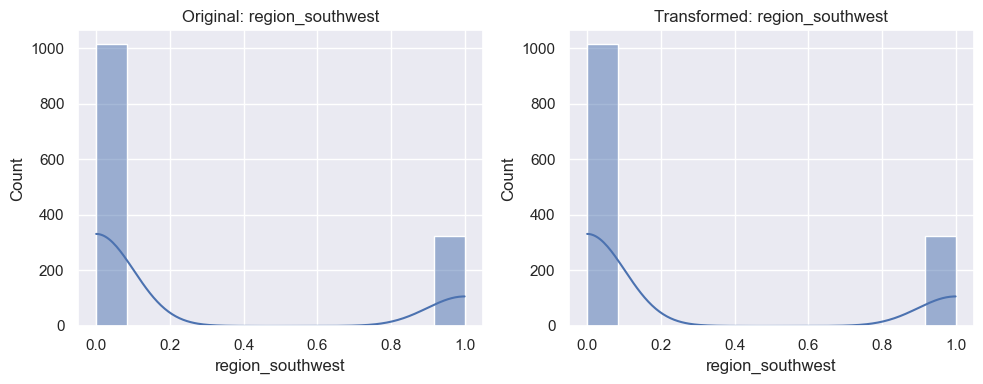

In [328]:
import matplotlib.pyplot as plt
import seaborn as sns

def compare_distributions(df_original, df_transformed, columns):
    for col in columns:
        plt.figure(figsize=(10,4))
        plt.subplot(1,2,1)
        sns.histplot(df_original[col], kde=True)
        plt.title(f"Original: {col}")

        plt.subplot(1,2,2)
        sns.histplot(df_transformed[col], kde=True)
        plt.title(f"Transformed: {col}")
        plt.tight_layout()
        plt.show()

compare_distributions(medical, transformed_medical, medical.columns)

## Analysis and Visualization of Linear Relation between X and Y

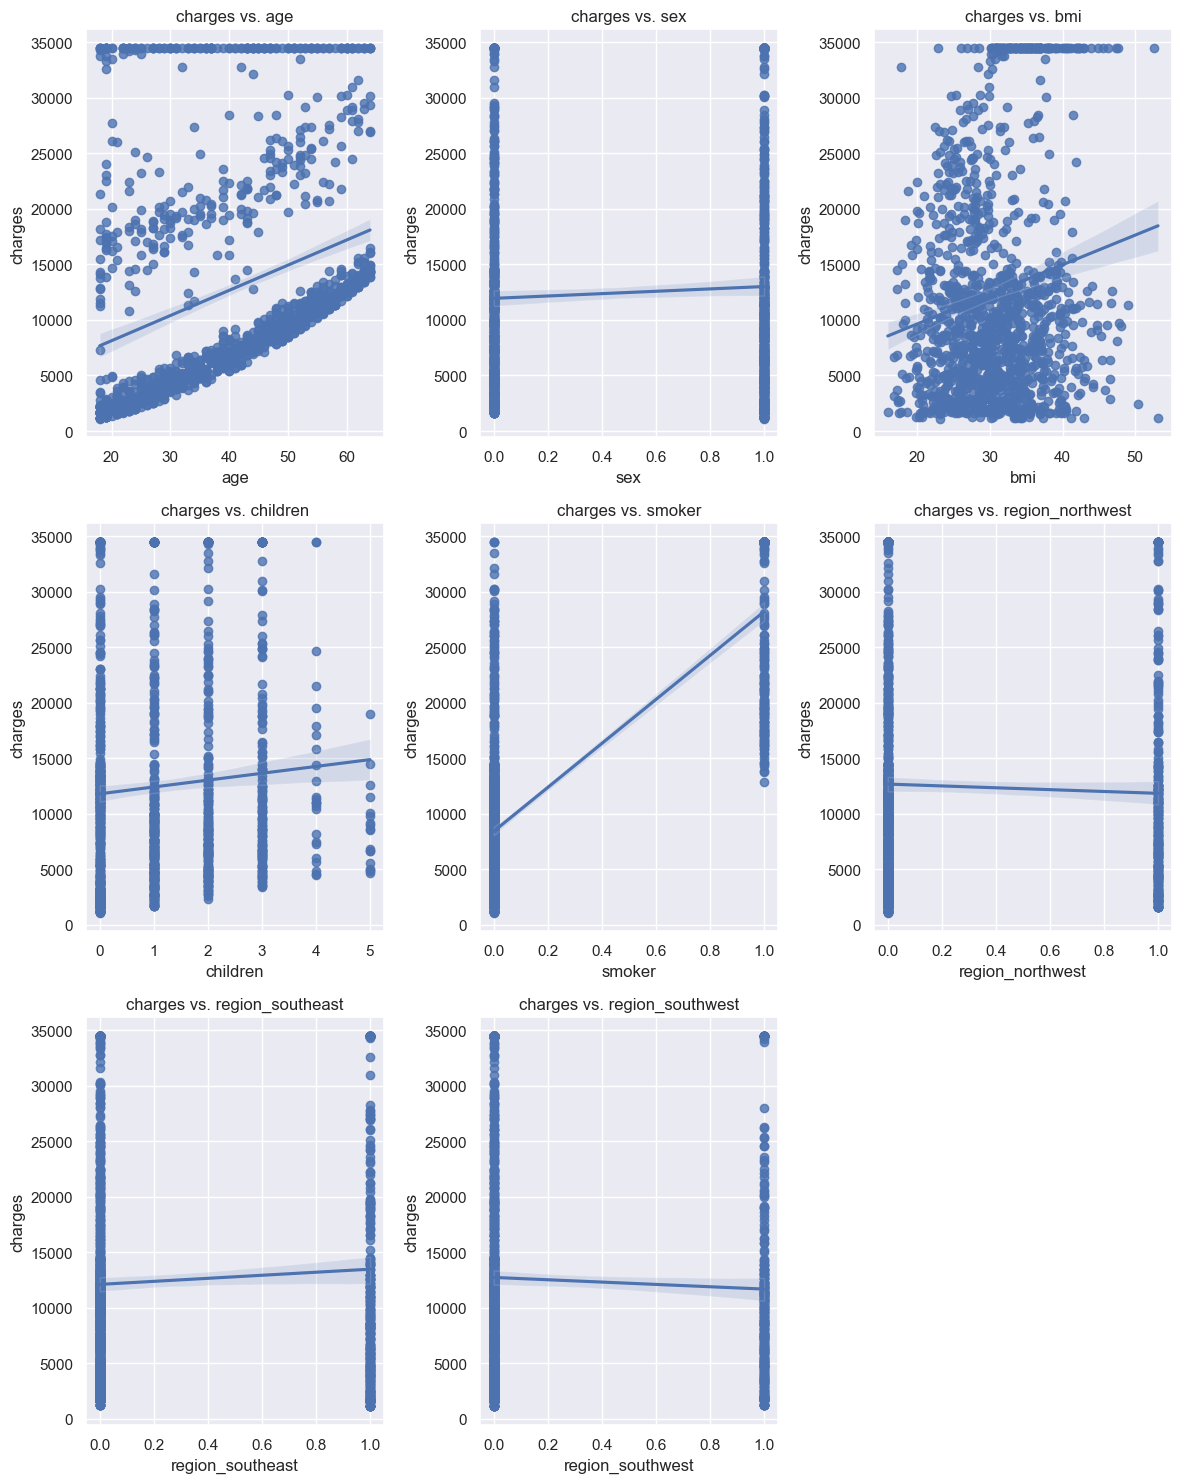

In [329]:
def plot_price_vs_vars(data, cols, target=target_col, cols_per_row=3):
    rows = (len(cols) + cols_per_row - 1) // cols_per_row  # Ceiling division
    fig, axes = plt.subplots(rows, cols_per_row, figsize=(12, 5 * rows))
    axes = axes.flatten()

    for i, col in enumerate(cols):
        sns.regplot(x=data[col], y=data[target], ax=axes[i])
        axes[i].set_title(f'{target} vs. {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel(target)

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

cols_to_use = [col for col in transformed_medical.columns if col != target_col]
plot_price_vs_vars(medical, cols_to_use)

All the X variables have poitive relation with price except thickness.

## Pair Plots all numerical columns on Transformed data


In [330]:
sns.pairplot(transformed_medical.drop(columns=["battery","thickness","weight"]))
plt.show()

KeyError: "['battery', 'thickness', 'weight'] not found in axis"

## Checking correlation between features on Transformed Data

In [ ]:
plt.figure(figsize=(10,10))
corr = transformed_medical.corr()
sns.heatmap(corr,cmap='coolwarm',annot=True,fmt='.2f')
plt.show()

### Feature Distribution (Hist Plot)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_distributions(data, columns, charts_per_row=2):
    num_cols = len(columns)
    num_rows = int(np.ceil(num_cols / charts_per_row))

    fig, axes = plt.subplots(num_rows, charts_per_row, figsize=(charts_per_row * 6, num_rows * 4))
    axes = axes.flatten()

    for i, col in enumerate(columns):
        sns.histplot(data[col], kde=True, color='red', ax=axes[i])
        axes[i].set_title(f'Distribution: {col}')
    
    # Hide unused subplots if any
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

cols_to_use = [
    col for col in transformed_medical.columns 
    if col not in ["price", "product_id", "sale", "weight", "battery", "thickness"]
]

plot_distributions(transformed_medical, cols_to_use, charts_per_row=2)

In [ ]:
medical.shape

# Common Model Building Function to be called with the ***required*** parameters

In [ ]:
def get_transform_info(col):
    try:
        best_transform = skew_summary.loc[skew_summary['Column'] == col, 'Best Transformation'].values[0]
        lambda_val = transform_metadata[col]['lambda']
        return best_transform, lambda_val
    except Exception as e:
        raise KeyError(f"Column '{col}' not found in skew_summary or metadata: {e}")

In [ ]:
def detransform(y_transformed, method,param=None):
       
    y_transformed = np.array(y_transformed)

    if method == 'log1p':
        return np.expm1(y_transformed)

    elif method == 'Original':
        return y_transformed

    elif method == 'sqrt':
        return np.square(y_transformed)

    elif method == 'boxcox':
        if param is None:
            raise ValueError("Box-Cox detransformation requires lambda parameter.")
        return inv_boxcox(y_transformed, param)

    elif method == 'yeojohnson':
        if param is None:
            raise ValueError("Yeo-Johnson detransformation requires lambda parameter.")
        #return inv_yeojohnson(y_transformed, param)
        return ((y_transformed * param) + 1) ** (1 / param) - 1

    else:
        raise ValueError(f"Unsupported transformation method: {method}")

## Inverse Transformation

In [ ]:
def reversetransformation(df):    
    #print("here")
    df_transformed = df.copy()
    #display(df)
    method, lmbda = get_transform_info(target_col)
    #print(target_col,"::",method,":",lmbda)
    detransform(df, method, param=lmbda)
    return df_transformed

In [ ]:
def reversetransformation_(df):
    
    #print("here")
    df_transformed = df.copy()
    #display(df)
    for col in df.columns:
        try:
            method, lmbda = get_transform_info(col)
            #print(col,"::",method,":",lmbda)
            df_transformed[col] = detransform(df[col], method, param=lmbda, feat="trans")
        except KeyError:
            print(f"[SKIP] No transformation metadata for column: {col}")
            continue
        except Exception as e:
            print(f"[ERROR] Could not reverse transform {col}: {e}")
            continue
    return df_transformed

In [ ]:
  def smape(y_true,y_pred):
      y_true, y_pred = np.array(y_true), np.array(y_pred)
      denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
      diff = np.abs(y_true - y_pred)    
      nonzero_mask = denominator != 0
      smape_value = np.mean(diff[nonzero_mask] / denominator[nonzero_mask]) * 100    
      return smape_value

In [ ]:
def mape(y_true, y_pred):
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

In [ ]:
def model_evaluation(x_train, y_train,x_test, y_test,hyper=None,param=None,handle=None):
    y = pd.DataFrame()
    #print("y_test before inverse is:",y_test)
    if x_train is None:
        raise ValueError("The 'x_train' parameter is mandatory and was not provided")
    if y_train is None:
        raise ValueError("The 'param' parameter is mandatory and was not provided")
    if x_test is None:
        raise ValueError("The 'y_train' parameter is mandatory and was not provided")
    if y_test is None:
        raise ValueError("The 'y_validation' parameter is mandatory and was not provided")
    if hyper is None:
        raise ValueError("The 'hyper' parameter is mandatory and was not provided. (True = Tuned) with Hyper Parameters")
    if param is None:
        raise ValueError("The 'param' parameter is mandatory and was not provided.scale,trans and both")
    if handle is None:
        raise ValueError("The 'handle' parameter is mandatory and is the same scalsr handle used for scaling")
       
   # Define models
    models = {
        "Linear Regression": LinearRegression(),
        "Lasso L1 Normalization": Lasso(),
        "LassoCV (Cross Validation) ": LassoCV(cv=5),
        "Ridge ": Ridge(),
        "RidgeCV ": RidgeCV(cv=5),
        "ElasticNet": ElasticNet(),
        "ElasticNetCV": ElasticNetCV(cv=5),
        'svr_poly': SVR(kernel ="poly"),
        'svr_lin' : SVR(kernel ="linear"),
        'svr_rbf' : SVR(kernel="rbf"),
        "Decision Tree": DecisionTreeRegressor(random_state=42),
        "Random Forest": RandomForestRegressor(random_state=42),
        "Gradient Boosting": GradientBoostingRegressor(random_state=42),
        "XGBoost": xgb.XGBRegressor(random_state=42, verbosity=0),
        "lgbm": LGBMRegressor(),
        "catboost": CatBoostRegressor(verbose=False),
        "adaboost": AdaBoostRegressor(),
        "voting Regresor": VotingRegressor(
            estimators=[('lr', LinearRegression()),('rf', RandomForestRegressor(n_estimators=100, random_state=42)),('knn', KNeighborsRegressor())]),
        "Bagging Regressor": BaggingRegressor(estimator=DecisionTreeRegressor(random_state=42),n_estimators=50, max_samples=0.8,max_features=0.8,random_state=42,n_jobs=-1 ),

    }

    models_tuned = {
        'Linear Regression' : LinearRegression(),
        'Lasso L1 Normalization' : Lasso(alpha=0.02310129700083160),
        'LassoCV (Cross Validation) ' : LassoCV(cv=5),
        'Ridge' : Ridge(alpha=0.02310129700083160),
        'RidgeCV' : RidgeCV(cv=5),
        'ElasticNet' : ElasticNet(alpha=0.0012328467394420659),
        'ElasticNetCV' : ElasticNetCV(cv=5),
        'svr_poly': SVR(kernel ="poly",epsilon=0.01,gamma="scale",C=0.1,coef0=1,degree=4),
        'svr_lin' : SVR(kernel ="linear",C=100,epsilon=0.01,gamma="scale"),
        'svr_rbf' : SVR(C=10,coef0=0,degree=2,epsilon=0.01,kernel ="rbf"),
        'Decision Tree': DecisionTreeRegressor(max_depth=5, min_samples_leaf=10, random_state=42),
        'Random Forest': RandomForestRegressor(n_estimators = 400, max_features= "sqrt",min_samples_leaf=5 ,random_state = 1, max_depth = 7),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators = 400, max_depth = 3,learning_rate=0.01,min_samples_leaf=5, random_state = 42),
        'XGBoost' : xgb.XGBRegressor(random_state = 111, max_depth = 3),
        "lgbm": LGBMRegressor(),
        "catboost": CatBoostRegressor(verbose=False),
        "adaboost": AdaBoostRegressor(),
        "voting Regresor": VotingRegressor(
            estimators=[('lr', LinearRegression()),('rf', RandomForestRegressor(n_estimators=100, random_state=42)),('knn', KNeighborsRegressor())]),
        "Bagging Regressor": BaggingRegressor(estimator=DecisionTreeRegressor(random_state=42),n_estimators=50, max_samples=0.8,max_features=0.8,random_state=42,n_jobs=-1 ),
        
    }
    results = []
    
    if hyper == False:
        selected = models        
    elif hyper == True:
        selected = models_tuned
    
    #print("Models Selected::",selected)
    
    for name, model in selected.items():
        model.fit(x_train, y_train)       
        
        
        if (param == "trans"):
            y_pred_t = model.predict(x_train)
            y_pred_v = model.predict(x_test)
            
            #y_pred_train  = reversetransformation(pd.DataFrame(y_pred_t, columns=[target_col]))
            #y_pred_validation  = reversetransformation(pd.DataFrame(y_pred_v, columns=[target_col]))

            #y_train  = reversetransformation(pd.DataFrame(y_train, columns=[target_col]))
            #y_test  = reversetransformation(pd.DataFrame(y_test, columns=[target_col]))

            y_pred_train  = reversetransformation(y_pred_t)
            y_pred_validation  = reversetransformation(y_pred_v)

            y_train  = reversetransformation(y_train)
            y_test  = reversetransformation(y_test)

            #print("y_pred after processing is:\n",y_pred_validation,"\n")
            #print("y_test after processing :", y_test)

        elif (param == "scale"):
            y_pred_t = model.predict(x_train)
            y_pred_v = model.predict(x_test)
            
            y_pred_train  = descale(scale,pd.DataFrame(y_pred_t))
            y_pred_validation  = descale(scale,pd.DataFrame(y_pred_v))

            y_train  = descale(scale,pd.DataFrame(y_train))
            y_test  = descale(scale,pd.DataFrame(y_test))

            #print("y_pred after processing is:\n",y_pred_validation,"\n")
            #print("y_test after processing :", y_test)
            
            
        elif (param == "both"):
            y_pred_t = model.predict(x_train)
            y_pred_v = model.predict(x_test)
            
            y_pred_train  = reversetransformation(descale(scale,pd.DataFrame(y_pred_t)))
            y_pred_validation  = reversetransformation(descale(scale,pd.DataFrame(y_pred_v)))

            y_train  = reversetransformation(descale(scale,pd.DataFrame(y_train)))
            y_test  = reversetransformation(descale(scale,pd.DataFrame(y_test)))

            #print("y_pred after processing is\n:",y_pred_validation,"\n")
            #print("y_test after processing :", y_test)
            
        else:                        
            y_pred_train = model.predict(x_train)
            y_pred_validation = model.predict(x_test)
            
            #print("y_pred is:\n",y_pred_validation,"\n")
            #print("y_test :", y_test)
            
        #print("Predicted Descale and detranaform",y_pred_train,"\n")
        #print("Scaled, transformed,",y_train)
        
        predict_comparison(model)
        train_rmse = np.sqrt(mean_squared_error(y_train , y_pred_train))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_validation))
        
        train_r2 = r2_score(y_train, y_pred_train)
        test_r2 = r2_score(y_test, y_pred_validation)
        
        n_train, p_train = x_train.shape
        n_test, p_test = x_test.shape
        train_adj_r2 = 100 * (1 - (1 - r2_score(y_train, y_pred_train) / 100) * (n_train - 1) / (n_train - p_train - 1))
        test_adj_r2 = 100 * (1 - (1 - r2_score(y_test, y_pred_validation) / 100) * (n_test - 1) / (n_test - p_test))
        
        overfitting = "Y" if train_r2 - test_r2 > 0.1 else "N"
        
        results.append({
            "Model": name,
            "Train MAE": mean_absolute_error(y_train, y_pred_train),
            "Test MAE": mean_absolute_error(y_test, y_pred_validation),
            
            "Train MSE": mean_squared_error(y_train, y_pred_train),
            "Test MSE": mean_squared_error(y_test, y_pred_validation),
            
            "Train SMAPE": smape(y_train,y_pred_train),
            "Test SMAPE_test Erro": smape(y_test,y_pred_validation),
            
            "Train MAPE_Train Error:": mape(y_train,y_pred_train),
            "Test MAPE_test Error": mape(y_test,y_pred_validation),
            
            "Train RMSE": round(train_rmse, 4),
            "Test RMSE": round(test_rmse, 4),
            
            "Train R²": round(train_r2, 4),
            "Test R²": round(test_r2, 4),
            
            "Train Adjusted R2":round(train_adj_r2,2),
            "Test Adjusted R2":test_adj_r2,
            
            "Overfitting (Y/N)": overfitting
        })
    
    comparison_df = pd.DataFrame(results)
    ordered_columns = ['Model', 'Train MAE','Test MAE','Train MSE','Test MSE','Train RMSE', 'Test RMSE',
                       'Train R²', 'Test R²','Train Adjusted R2','Test Adjusted R2' ,'Overfitting (Y/N)']
    
    comparison_raw = comparison_df[ordered_columns]
    #return comparison_raw

    #####comparison_raw =  model_evaluation(medical,"price",raw=True)
    display(comparison_raw)

    filtered = comparison_raw[comparison_raw['Overfitting (Y/N)'] == 'N']

    filtered = filtered.copy()
    filtered['Score'] = filtered['Test R²'] - (filtered['Test RMSE'] / filtered['Test RMSE'].max())

    # Get the best model
    best_model_row = filtered.loc[filtered['Score'].idxmax()]
    best_model_name = best_model_row['Model']

    print("Best Model Based on Score:")
    display(pd.DataFrame(best_model_row[['Model', 'Train RMSE', 'Test RMSE', 'Train R²', 'Test R²']])) 
    #print(y)      


# Inverse Scaling

In [ ]:
#New 
def scale_descale_columns(scale,df, columns_to_scale,param=None):
    if handle is None:
        raise ValueError("The 'handle' parameter is mandatory.This should be the same instace of scaling method)")
    if scaled_data is None:
        raise ValueError("The 'scaled_data' parameter is mandatory.This should be the scaled data)")  
        
    if (param == "scale"):        
        df_scaled = df.copy()
        df_scaled[columns_to_scale] = scaler.fit_transform(df_scaled[columns_to_scale])
        return df_scaled, scaler
    elif(param == "descale"):
        scaled_df, scaler = standard_scale_columns(df, columns_to_scale)

In [ ]:
def descale(handle,scaled_data):
    if handle is None:
        raise ValueError("The 'handle' parameter is mandatory.This should be the same instace of scaling method)")
    if scaled_data is None:
        raise ValueError("The 'scaled_data' parameter is mandatory.This should be the scaled data)")    
        
    original = handle.inverse_transform(scaled_data)
    original_df = pd.DataFrame(original, columns=scaled_data.columns,index=scaled_data.index)    
    return original_df

# Split and Scale 

In [ ]:
def split_scale(scale_handle,df,target_col,scale=False):
    if scale == True:
        if scale_handle is None:
            raise ValueError("The 'scale handle' parameter is mandatory as scaling is True)")
            
    if df is None:
        raise ValueError("The 'df' parameter is mandatory.This should be the dataFrame)")
    if target_col is None:
        raise ValueError("The 'target_col' parameter is mandatory.This should be the target Variable)")     
 
    
    train, validation = train_test_split(df,train_size=0.75, random_state=1)    
    x_train = train.drop([target_col],axis=1)
    y_train =pd.DataFrame(train[target_col])
    
    x_validation = validation.drop([target_col],axis=1)
    y_validation = pd.DataFrame(validation[target_col])
    if (scale == True):
        x_train = pd.DataFrame(scale_handle.fit_transform(x_train), columns=x_train.columns, index=x_train.index)
        y_train = pd.DataFrame(scale_handle.fit_transform(y_train), columns=y_train.columns, index=y_train.index)
        x_validation = pd.DataFrame(scale_handle.fit_transform(x_validation), columns=x_validation.columns, index=x_validation.index)
        y_validation = pd.DataFrame(scale_handle.fit_transform(y_validation), columns=y_validation.columns, index=y_validation.index)
    return x_train,y_train,x_validation,y_validation

In [331]:
medical.skew()

age                 0.055673
sex                -0.020951
bmi                 0.284047
children            0.938380
smoker              1.464766
charges             1.083730
region_northwest    1.200409
region_southeast    1.025621
region_southwest    1.200409
dtype: float64

# Scaling Methods

| Transformer Class      | What `transform()` Does                                           | Purpose                         |
| ---------------------- | ----------------------------------------------------------------- | ------------------------------- |
| `StandardScaler()`     | Subtracts mean, divides by std (z-score)                          | Standardization (mean=0, std=1) |
| `MinMaxScaler()`       | Scales to a fixed range (default \[0, 1])                         | Normalization                   |
| `RobustScaler()`       | Scales using median and IQR (less sensitive to outliers)          | Robust normalization            |
| `PowerTransformer()`   | Applies **Yeo-Johnson** or **Box-Cox** for variance stabilization | Make data more Gaussian         |
| `OneHotEncoder()`      | Converts categorical variables to binary (0/1) columns            | Categorical encoding            |
| `LabelEncoder()`       | Converts categories to integers (e.g., A=0, B=1)                  | Label encoding                  |
| `PCA()`                | Projects data onto principal components (linear combinations)     | Dimensionality reduction        |
| `SimpleImputer()`      | Fills missing values with mean/median/mode                        | Handling missing data           |
| `PolynomialFeatures()` | Expands features to include polynomial terms                      | Feature expansion               |


In [332]:
#scale = RobustScaler()
#scale = MinMaxScaler()
scale = StandardScaler()
#scale = PowerTransformer()

# Select Data Models

In [ ]:
def select_data(param=None):
    if(param == 1):
        print("You have selected Transformed Data")
        return transformed_medical
    if(param == 2):
        print("You have selected Outlier Treated Data")
        return medical_iqr
    if(param == 3):
        print("You have selected raw Data")
        return medical  

In [ ]:
inpu = input("Enter the Value: \n 1: For Transformed Data \n 2: for Outlier Treated Data\n 3: for raw Data\n")
scaled_medical = select_data(int(inpu))

# Model Building on Raw/Untreated Data

In [333]:
transformed_medical.skew()

age                 0.055673
sex                -0.020951
bmi                -0.006617
children            0.105254
smoker              1.464766
charges            -0.028875
region_northwest    1.200409
region_southeast    1.025621
region_southwest    1.200409
dtype: float64

In [334]:
#x_train, y_train,x_test, y_test = split_scale(scale_handle=None,df=medical,target_col=target_col,scale=False)
#model_evaluation(x_train, y_train,x_test, y_test,hyper=False,param="raw",handle=scale)

# Model Building on Transformed Data

In [335]:
x_train, y_train,x_test, y_test = split_scale(scale_handle=scale,df=transformed_medical,target_col=target_col,scale=True)
model_evaluation(x_train, y_train,x_test, y_test,hyper=True,param="both",handle=scale)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000197 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 325
[LightGBM] [Info] Number of data points in the train set: 1003, number of used features: 8
[LightGBM] [Info] Start training from score 6987832.581256


,Model,Train MAE,Test MAE,Train MSE,Test MSE,Train RMSE,Test RMSE,Train R²,Test R²,Train Adjusted R2,Test Adjusted R2,Overfitting (Y/N)
0,Linear Regression,8.352551e-01,8.074255e-01,1.682542e+00,1.602064e+00,1.297100e+00,1.265700e+00,0.7529,0.7647,-0.05,-1.359622,N
1,Lasso L1 Normalization,2.183624e+00,2.102418e+00,1.151079e+01,1.104587e+01,3.392800e+00,3.323500e+00,0.7517,0.7617,-0.05,-1.362682,N
2,LassoCV (Cross Validation),5.684860e+00,5.492991e+00,7.798809e+01,7.429778e+01,8.831100e+00,8.619600e+00,0.7529,0.7645,-0.05,-1.359759,N
3,Ridge,1.483746e+01,1.434309e+01,5.309321e+02,5.055380e+02,2.304200e+01,2.248420e+01,0.7529,0.7647,-0.05,-1.359622,N
4,RidgeCV,3.872899e+01,3.743784e+01,3.614637e+03,3.442016e+03,6.012190e+01,5.866870e+01,0.7529,0.7647,-0.05,-1.359641,N
5,ElasticNet,1.010376e+02,9.766966e+01,2.460868e+04,2.343285e+04,1.568715e+02,1.530779e+02,0.7529,0.7647,-0.05,-1.359635,N
6,ElasticNetCV,2.943667e+02,2.860681e+02,1.845292e+05,1.788768e+05,4.295687e+02,4.229383e+02,0.7278,0.7361,-0.07,-1.388781,N
7,svr_poly,1.641036e+03,1.602977e+03,4.012773e+06,4.010644e+06,2.003191e+03,2.002659e+03,0.1305,0.1310,-0.67,-2.006867,N
8,svr_lin,1.555000e+03,1.509512e+03,8.716226e+06,7.771029e+06,2.952325e+03,2.787657e+03,0.7226,0.7527,-0.08,-1.371880,N
9,svr_rbf,1.135657e+04,1.110424e+04,1.934318e+08,1.939446e+08,1.390798e+04,1.392640e+04,0.0958,0.0934,-0.71,-2.045313,N


Best Model Based on Score:


,12
Model,Gradient Boosting
Train RMSE,105031.7061
Test RMSE,106542.713
Train R²,0.8366
Test R²,0.8318


In [275]:
descale(scale,y_test)

,charges
559,11.976092
1087,17.295053
1020,16.519680
460,17.020156
802,12.583623
...,...
1192,17.721498
628,17.298513
1098,19.578153
1038,12.755353


# Common Function for Individual Model Evaluation

In [133]:
def model_performance(model, x_train, y_train,x_validation, y_validation):
    model.fit(x_train, y_train)
    y_pred_train = model.predict(x_train)
    y_pred_validation = model.predict(x_validation)

    mask_train = y_train != 0
    mape_train = np.mean(np.abs((y_train[mask_train] - y_pred_train[mask_train]) / y_train[mask_train])) * 100

    mask_validate = y_validation != 0
    mape_test = np.mean(np.abs((y_validation[mask_validate] - y_pred_validation[mask_validate]) / y_validation[mask_validate])) * 100

    n_train, p_train = x_train.shape
    n_test, p_test = x_validation.shape
    train_adj_r2 = 100 * (1 - (1 - r2_score(y_train, y_pred_train) / 100) * (n_train - 1) / (n_train - p_train - 1))
    test_adj_r2 = 100 * (1 - (1 - r2_score(y_validation, y_pred_validation) / 100) * (n_test - 1) / (n_test - p_test - 1))

    #coefficients = pd.Series(model.coef_, index=pd.DataFrame(x_train).columns)
    #features_linear = coefficients[coefficients != 0].sort_values(key=np.abs, ascending=False)
    
    print("\nAccuracy Scores for Linear Regression model on tranaformed and Scaled data::")
    print("*R2 score:Train",r2_score(y_train, y_pred_train))
    print("*R2 score:",r2_score(y_validation, y_pred_validation),"\n")
    print("*Adjusted R2 score:Train",train_adj_r2)
    print("*Adjusted R2 score:Test",test_adj_r2,"\n")
    print("*MAE:Train",mean_absolute_error(y_train, y_pred_train))
    print("*MAE:Validation",mean_absolute_error(y_validation, y_pred_validation),"\n")
    print("*MSE:Train",mean_squared_error(y_train, y_pred_train))
    print("*MSE:Validation",mean_squared_error(y_validation, y_pred_validation),"\n")
    print("*RMSE:Train",np.sqrt(mean_squared_error(y_train, y_pred_train)))
    print("*RMSE:Train",np.sqrt(mean_squared_error(y_validation, y_pred_validation)),"\n")
    print("*SMAPE_Train Error:",smape(y_train,y_pred_train))
    print("*SMAPE_test Error", smape(y_validation,y_pred_validation),"\n")
    print("*MAPE_Train Error:",mape(y_train,y_pred_train))
    print("*MAPE_test Error", mape(y_validation,y_pred_validation),"\n")
    #print("Coefficints are:\n",coefficients)
    #print("\nCoefficints are:\n",features_linear)
    return model

In [134]:
train, validation = train_test_split(scaled_medical,train_size=0.75, random_state=1)
x_train = train.drop(["price"],axis=1)
y_train =train["price"]

x_validation = validation.drop(["price"],axis=1)
y_validation = validation["price"]

# Linear Regression model

## Model Building

In [135]:
linear = model_performance(model=LinearRegression(),x_train=x_train,y_train=y_train,x_validation=x_validation,y_validation=y_validation)


Accuracy Scores for Linear Regression model on tranaformed and Scaled data::
*R2 score:Train 0.8791455905674962
*R2 score: 0.9141494979801157 

*Adjusted R2 score:Train -10.237211913294097
*Adjusted R2 score:Test -41.55121500288554 

*MAE:Train 343.3839241566601
*MAE:Validation 290.9485816691544 

*MSE:Train 203694.84945650055
*MSE:Validation 139410.79328486446 

*RMSE:Train 451.3256578752205
*RMSE:Train 373.377547912116 

*SMAPE_Train Error: 10.295751592834247
*SMAPE_test Error 9.192493633839549 

*MAPE_Train Error: 10.52521036658696
*MAPE_test Error 9.391412663762459 



## Cross Validation

In [136]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
lin_model = LinearRegression()

cv_r2_scores = cross_val_score(linear, x_train, y_train, scoring='r2', cv=kf)
cv_mse_scores = -cross_val_score(linear, x_train, y_train, scoring='neg_mean_squared_error', cv=kf)

print("Cross-validated R² scores:", cv_r2_scores)
print("Average R²:", np.mean(cv_r2_scores))
print("Average MSE:", np.mean(cv_mse_scores))

Cross-validated R² scores: [0.90510599 0.87297373 0.75345575 0.87875661 0.70462813]
Average R²: 0.8229840429789517
Average MSE: 268341.9912227599


## Residual Analysis - Fit base Linear Regression

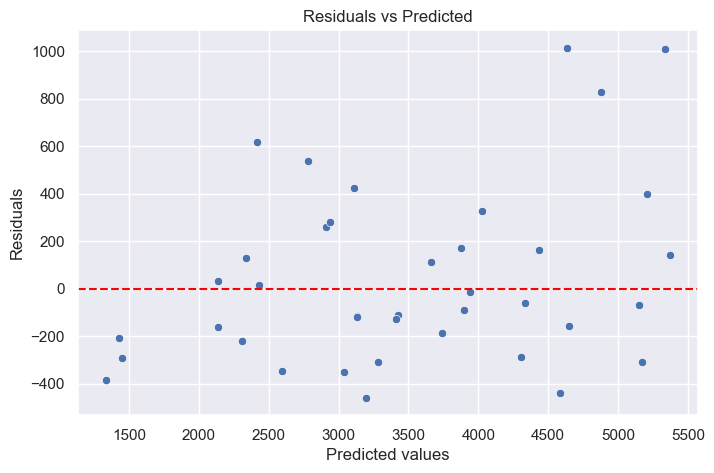

In [137]:
linear.fit(x_train, y_train)
y_pred = model.predict(x_validation)

residuals = y_validation - y_pred

plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()


## Feature Importance

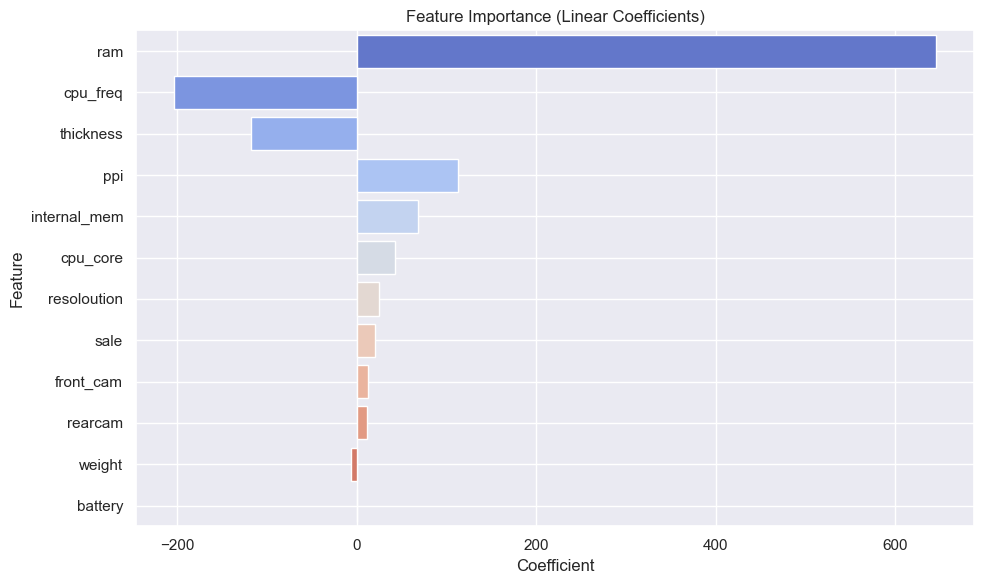

In [138]:
feature_names = x_train.columns
coefficients = linear.coef_

coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients
}).sort_values(by="Coefficient", key=abs, ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=coef_df, x="Coefficient", y="Feature", palette="coolwarm")
plt.title("Feature Importance (Linear Coefficients)")
plt.grid(True)
plt.tight_layout()
plt.show()

## linear_model  actual v/s Predicted comparison

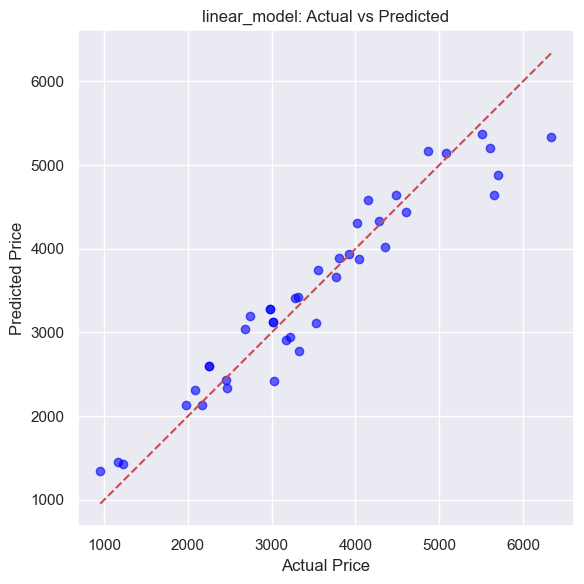

In [139]:
y_pred = linear.predict(x_validation)
plt.figure(figsize=(6, 6))
plt.scatter(y_validation, y_pred, alpha=0.6, color='blue')
plt.plot([y_validation.min(), y_validation.max()], [y_validation.min(), y_validation.max()], '--r')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("linear_model: Actual vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

# Lasso

## Grid Search for Hyperparameter Tuning in Lasso Regression

In [388]:
#Approach1# Define a wide range of alpha values on a log scale
alphas = np.logspace(-4, 2, 100)  # 0.0001 to 100
best_score = float('-inf')
best_alpha = None

# Loop through alphas and use cross-validation to find the best
for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    # Use negative MSE as scoring (standard in sklearn)
    scores = cross_val_score(lasso, x_train, y_train, cv=5, scoring='neg_mean_squared_error')
    #scores = cross_val_score(lasso, x_train, y_train, cv=5, scoring='r2')
    mean_score = scores.mean()

    if mean_score > best_score:  # since scores are negative
        best_score = mean_score
        best_alpha = alpha

print(f"Best Alpha: {best_alpha}")
print(f"Best Cross-Validation Score (Negative MSE): {best_score}")
print(f"Actual MSE: {abs(best_score)}")


Best Alpha: 0.013219411484660288
Best Cross-Validation Score (Negative MSE): -0.15022264729309776
Actual MSE: 0.15022264729309776


In [389]:
#Approach2 # To be used with Lasso() not with LassoCV()
lassol1 = Lasso()
alpha_range = {'alpha': [0.01, 0.1, 0.2,0.3,0.4,0.5,0.6,.7,.8,.9,1, 10, 100, 1000]}
grid_search = GridSearchCV(estimator=lassol1, param_grid=alpha_range, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(x_train, y_train)
best_alpha = grid_search.best_params_['alpha']
best_score = grid_search.best_score_

print("Best Alpha:", best_alpha)
print("Best Cross-Validation Score:", best_score)

Best Alpha: 0.01
Best Cross-Validation Score: -0.15095374361102581


## Model Buildiong Lasso Regression (L1 Regularization)

In [ ]:
#model  = model_performance(model=Lasso(alpha=1),x_train=x_train,y_train=y_train,x_validation=x_validation,y_validation=y_validation)
#model  = model_performance(model=LassoCV(cv=5),x_train=x_train,y_train=y_train,x_validation=x_validation,y_validation=y_validation)

## lasso  actual v/s Predicted comparison

In [ ]:
y_pred = lasso.predict(x_validation)
plt.figure(figsize=(6, 6))
plt.scatter(y_validation, y_pred, alpha=0.6, color='blue')
plt.plot([y_validation.min(), y_validation.max()], [y_validation.min(), y_validation.max()], '--r')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("lasso: Actual vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

# Ridge

## Grid Search for Hyperparameter Tuning in Ridge Regression

In [ ]:
#Approach1# Define a wide range of alpha values on a log scale
alphas = np.logspace(-4, 2, 100)  # 0.0001 to 100

best_score = float('-inf')
best_alpha = None
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Loop through alphas and use cross-validation to find the best
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    # Use negative MSE as scoring (standard in sklearn)
    scores = cross_val_score(ridge, x_train, y_train, cv=5, scoring='neg_mean_squared_error')
    #scores = cross_val_score(ridge, x_train, y_train, cv=5, scoring='r2')
    mean_score = scores.mean()

    if mean_score > best_score:  # since scores are negative
        best_score = mean_score
        best_alpha = alpha

print(f"Best Alpha: {kfold}")
print(f"Best Alpha: {best_alpha}")
print(f"Best Cross-Validation Score (Negative MSE): {best_score}")
print(f"Actual MSE: {abs(best_score)}")


In [ ]:
#Approach2 # To be used with Ridge() not with RidgeCV()

ridge_model = Ridge()
alpha_range = {'alpha': [0.01, 0.1, .2,.3,.4,.5,.6,.7,.8,.9,1, 10, 100, 1000]}
#alpha_range = {'alpha': np.logspace(-4, 2, 100)}
grid_search = GridSearchCV(estimator=ridge_model, param_grid=alpha_range, cv=68, scoring='neg_mean_squared_error')
grid_search.fit(x_train, y_train)
best_alpha = grid_search.best_params_['alpha']
best_score = grid_search.best_score_

print("Best Alpha:", best_alpha)
print("Best Cross-Validation Score:", best_score)

## Ridge Regression (L2 Regularization)

In [ ]:
#model = model_performance(model=Ridge(alpha=10.722672220103231),x_train=x_train,y_train=y_train,x_validation=x_validation,y_validation=y_validation)
model  = model_performance(model=RidgeCV(cv=5),x_train=x_train,y_train=y_train,x_validation=x_validation,y_validation=y_validation)

## ridge  actual v/s Predicted comparison

In [ ]:
y_pred = ridge.predict(x_validation)
plt.figure(figsize=(6, 6))
plt.scatter(y_validation, y_pred, alpha=0.6, color='blue')
plt.plot([y_validation.min(), y_validation.max()], [y_validation.min(), y_validation.max()], '--r')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("ridge: Actual vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

## Grid Search for Hyperparameter Tuning in ElasticNet Regression

In [ ]:
#Approach1# Define a wide range of alpha values on a log scale
alphas = np.logspace(-4, 2, 100)  # 0.0001 to 100

best_score = float('-inf')
best_alpha = None
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
# Loop through alphas and use cross-validation to find the best
for alpha in alphas:
    elastic = ElasticNet(alpha=alpha)
    # Use negative MSE as scoring (standard in sklearn)
    scores = cross_val_score(elastic, x_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    #scores = cross_val_score(elastic, x_train, y_train, cv=5, scoring='r2')
    mean_score = scores.mean()

    if mean_score > best_score:  # since scores are negative
        best_score = mean_score
        best_alpha = alpha

print(f"Best KFold: {kfold}")
print(f"Best Alpha: {best_alpha}")
print(f"Best Cross-Validation Score (Negative MSE): {best_score}")
print(f"Actual MSE: {abs(best_score)}")


In [ ]:
#Grid Search for Hyperparameter Tuning in Elastic net Regression

elastic_model = ElasticNet()
alpha_range = {'alpha': [0.01,0.02,0.04,0.04, 0.1, .2,.3,.4,.5,.6,.7,.8,.9,1, 10, 100, 1000]}
grid_search = GridSearchCV(estimator=elastic_model, param_grid=alpha_range, cv=68, scoring='neg_mean_squared_error')
grid_search.fit(x_train, y_train)
best_alpha = grid_search.best_params_['alpha']
best_score = grid_search.best_score_

print("Best Alpha:", best_alpha)
print("Best Cross-Validation Score:", best_score)

In [ ]:
# Elastic Net Regression (L1 and L2 Regularization)
#model_performance(model=ElasticNet(alpha=0.0012328467394420659),x_train=x_train,y_train=y_train,x_validation=x_validation,y_validation=y_validation)
model_performance(model=ElasticNetCV(cv=5),x_train=x_train,y_train=y_train,x_validation=x_validation,y_validation=y_validation)

elastic = ElasticNet(alpha=0.0012328467394420659)
#elastic = ElasticNetCV(cv=5)
elastic.fit(x_train,y_train)

elastic_predict_train_data = elastic.predict(x_train)
elastic_predict_validate_data = elastic.predict(x_validation)

coefficients = pd.Series(elastic.coef_, index=pd.DataFrame(x_train).columns)
features_elastic = coefficients[coefficients != 0].sort_values(key=np.abs, ascending=False)

elastic_mse_validate = mean_squared_error(y_validation,elastic_predict_validate_data)  #  Test Error
elastic_mse_train = mean_squared_error(y_train,elastic_predict_train_data)             #  Train Error

elastic_r2_validate = r2_score(y_validation,elastic_predict_validate_data)
elastic_r2_train = r2_score(y_train,elastic_predict_train_data)

#print("Coefficints are:\n",coefficients)
#print("\nCoefficints are:\n",features_elastic)

print("\nAccuracy Scores for Elastic net Regression (L1 Regularization) model on raw data::")
if(hasattr(lasso, "alpha")):
        print("->Alpha are:",lasso.alpha)
if(hasattr(lasso, "alpha_")):
        print("->Alpha are:",lasso.alpha_)
print("->elastic_mean square error_train_data:", elastic_mse_train)
print("->elastic_mean square error_test_data:", elastic_mse_validate)

print("->elastic_r2 square error_train_data:", elastic_r2_train)
print("->elastic_r2 square error_test_data:", elastic_r2_validate)

print("\nMSE Value are : \nLess than 0 -> Good \n1-2-->Better\n2-3 -> Average")

In [ ]:
#elastic  actual v/s Predicted comparison

y_pred = elastic.predict(x_validation)
plt.figure(figsize=(6, 6))
plt.scatter(y_validation, y_pred, alpha=0.6, color='blue')
plt.plot([y_validation.min(), y_validation.max()], [y_validation.min(), y_validation.max()], '--r')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("elastic: Actual vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

## GridSearchCV for Decision Tree Regressor

In [ ]:

dtree = DecisionTreeRegressor(random_state=42)

# Define the parameter grid
param_grid = {
    'max_depth': [2, 3, 4, 5, 6],
    'min_samples_leaf': [5, 10, 15, 20]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=dtree,
                           param_grid=param_grid,
                           cv=10,
                           scoring='neg_mean_squared_error',  # or use 'r2'
                           n_jobs=-1)

# Fit to the training data
grid_search.fit(x_train, y_train)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best MSE Score:", -grid_search.best_score_)

In [ ]:
#Approach1# Define a wide range of alpha values on a log scale
alphas = np.logspace(-4, 2, 100)  # 0.0001 to 100

best_score = float('-inf')
best_alpha = None
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
# Loop through alphas and use cross-validation to find the best
for alpha in alphas:
    #elastic = ElasticNet(alpha=alpha)
    dtree = DecisionTreeRegressor(random_state=42)
    # Use negative MSE as scoring (standard in sklearn)
    scores = cross_val_score(dtree, x_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    #scores = cross_val_score(elastic, x_train, y_train, cv=5, scoring='r2')
    mean_score = scores.mean()

    if mean_score > best_score:  # since scores are negative
        best_score = mean_score
        best_alpha = alpha

print(f"Best KFold: {kfold}")
print(f"Best Alpha: {best_alpha}")
print(f"Best Cross-Validation Score (Negative MSE): {best_score}")
print(f"Actual MSE: {abs(best_score)}")


In [ ]:
# Decission Tree regression - Choosing max depth as 6 after trying different values
dtree = DecisionTreeRegressor(ccp_alpha=0.0001,max_depth=5, min_samples_leaf=5, random_state=42)
#model_performance(model=dtree,x_train=x_train,y_train=y_train,x_validation=x_validation,y_validation=y_validation)
model_performance(model=dtree,x_train=x_train,y_train=y_train,x_validation=x_validation,y_validation=y_validation)

####################################################################################
dtree.fit(x_train,y_train)
dtree_predict_train_data = dtree.predict(x_train)
dtree_predict_validation_data = dtree.predict(x_validation)

dtree_mse_validate = mean_squared_error(y_validation,dtree_predict_validation_data)  #  Test Error
dtree_mse_train = mean_squared_error(y_train,dtree_predict_train_data)             #  Train Error


dtree_r2_validate = r2_score(y_validation,dtree_predict_validation_data)
dtree_r2_train = r2_score(y_train,dtree_predict_train_data)

r2_scores = cross_val_score(dtree, x_train, y_train, cv=8, scoring='r2')
print("Crooss Val score R² for each fold:", r2_scores)
print("Crooss Val score Average R²:", np.mean(r2_scores))

print("\nAccuracy Scores for Decission Tree regression model on raw data::")
print("->Dtree_mean square error_train_data:", dtree_mse_train)
print("->Dtree_mean square error_test_data:", dtree_mse_validate)

print("->Dtree_r2 square error_train_data:", dtree_r2_train)
print("->Dtree_2 square error_test_data:", dtree_r2_validate)

print("\nMSE Value are : \nLess than 0 -> Good \n1-2-->Better\n2-3 -> Average")

In [ ]:
#dtree  actual v/s Predicted comparison

y_pred = dtree.predict(x_validation)
plt.figure(figsize=(6, 6))
plt.scatter(y_validation, y_pred, alpha=0.6, color='blue')
plt.plot([y_validation.min(), y_validation.max()], [y_validation.min(), y_validation.max()], '--r')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("dtree: Actual vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

# Random Forest

## GridSearchCV for Random Forest Regressor

In [426]:
rf = RandomForestRegressor(random_state=42)
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [7, 9, 11],
    'min_samples_leaf': [5, 10],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False],
    'criterion': ['squared_error', 'absolute_error']
}
rf_grid_search = GridSearchCV(
    estimator=rf,
    param_grid=rf_param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

rf_grid_search.fit(x_train, y_train)

print("Best Random Forest Parameters:", rf_grid_search.best_params_)
print("Best Random Forest CV R² Score:", rf_grid_search.best_score_)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best Random Forest Parameters: {'bootstrap': False, 'criterion': 'squared_error', 'max_depth': 9, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 300}
Best Random Forest CV R² Score: 0.9019634150220609


## RandomSearchCV for Random Forest Regressor

In [434]:
rf = RandomForestRegressor()
search = RandomizedSearchCV(estimator=rf, param_distributions=rf_param_grid, 
                            n_iter=50, cv=5, verbose=2, n_jobs=-1)
search.fit(x_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['squared_error',
                                                      'absolute_error'],
                                        'max_depth': [7, 9, 11],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [5, 10],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300]},
                   verbose=2)

## Model Tuning

In [438]:
rforest = RandomForestRegressor(bootstrap=False, max_depth=11, max_features='sqrt',
                      min_samples_leaf=5, min_samples_split=5,
                      n_estimators=300)
rforest.fit(x_train,y_train)

rforest_predict_train_data = rforest.predict(x_train)
rforest_predict_validation_data = rforest.predict(x_validation)

rforest_mse_validate = mean_squared_error(y_validation,rforest_predict_validation_data)  #  Test Error
rforest_mse_train = mean_squared_error(y_train,rforest_predict_train_data)             #  Train Error

rforest_r2_validate = r2_score(y_validation,rforest_predict_validation_data)
rforest_r2_train = r2_score(y_train,rforest_predict_train_data)

r2_scores = cross_val_score(rforest, x_train, y_train, cv=8, scoring='r2')
print("Crooss Val score R² for each fold:", r2_scores)
print("Crooss Val score Average R²:", np.mean(r2_scores))

print("\nAccuracy Scores for Random Forest regression model on raw data::")
print("->rforest_mean square error_train_data:", rforest_mse_train)
print("->rforest_mean square error_test_data:", rforest_mse_validate)

print("->rforest_r2 square error_train_data:", rforest_r2_train)
print("->rforest_2 square error_test_data:", rforest_r2_validate)

print("\nMSE Value are : \nLess than 0 -> Good \n1-2-->Better\n2-3 -> Average")

Crooss Val score R² for each fold: [0.90756623 0.92686101 0.89188427 0.85348723 0.92495482 0.87260718
 0.97551624 0.92703266]
Crooss Val score Average R²: 0.9099887034332891

Accuracy Scores for Random Forest regression model on raw data::
->rforest_mean square error_train_data: 0.03222208195923321
->rforest_mean square error_test_data: 0.0422985097279571
->rforest_r2 square error_train_data: 0.9678693084323411
->rforest_2 square error_test_data: 0.9562220390412584

MSE Value are : 
Less than 0 -> Good 
1-2-->Better
2-3 -> Average


## Random forest  actual v/s Predicted comparison

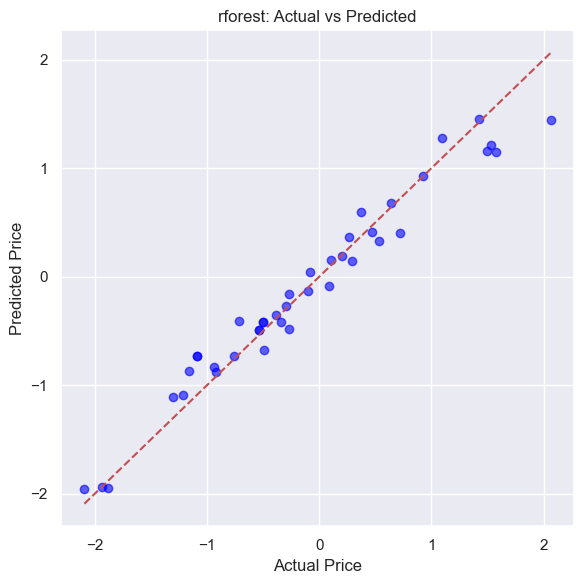

In [445]:
y_pred = rforest.predict(x_validation)
plt.figure(figsize=(6, 6))
plt.scatter(y_validation, y_pred, alpha=0.6, color='blue')
plt.plot([y_validation.min(), y_validation.max()], [y_validation.min(), y_validation.max()], '--r')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("rforest: Actual vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

# Gradient Boosting

## GridSearchCV for Gradient Boosting Regressor

In [ ]:
gb = GradientBoostingRegressor(random_state=42)
gb_param_grid = {
    'n_estimators': [100, 200, 300, 400],         # Number of boosting rounds
    'learning_rate': [0.01, 0.05, 0.1, 0.2],      # Step size shrinkage
    'max_depth': [3, 5, 7, 9],                    # Max depth of individual estimators
    'min_samples_split': [2, 5, 10],              # Min samples to split an internal node
    'min_samples_leaf': [1, 3, 5],                # Min samples at leaf node
    'subsample': [0.6, 0.8, 1.0],                 # Fraction of samples to use for fitting each base learner
    'max_features': ['sqrt', 'log2', None],       # Number of features to consider per split
    'loss': ['squared_error', 'absolute_error']   # Loss function
}

gb_grid_search = GridSearchCV(
    estimator=gb,
    param_grid=gb_param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)
gb_grid_search.fit(x_train, y_train)
print("Best Gradient Boosting Parameters:", gb_grid_search.best_params_)
print("Best Gradient Boosting CV R² Score:", gb_grid_search.best_score_)

Fitting 5 folds for each of 10368 candidates, totalling 51840 fits


## RandomSearchCV for Gradient Boosting Regressor

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV

gb = GradientBoostingRegressor()

gb_search = RandomizedSearchCV(
    estimator=gb,
    param_distributions=gb_param_grid,
    n_iter=50,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=2,
    n_jobs=-1,
    random_state=42
)
gb_search.fit(x_train, y_train)

## Model Tuning

In [399]:
# Gradient Boosting Regression model
gboost = GradientBoostingRegressor(n_estimators = 400, max_depth = 3,learning_rate=0.01,min_samples_leaf=5, random_state = 42)
gboost.fit(x_train,y_train)

gboost_predict_train_data = gboost.predict(x_train)
gboost_predict_validation_data = gboost.predict(x_validation)

gboost_mse_validate = mean_squared_error(y_validation,gboost_predict_validation_data)  #  Test Error
gboost_mse_train = mean_squared_error(y_train,gboost_predict_train_data)             #  Train Error

gboost_r2_validate = r2_score(y_validation,gboost_predict_validation_data)
gboost_r2_train = r2_score(y_train,gboost_predict_train_data)

r2_scores = cross_val_score(gboost, x_train, y_train, cv=8, scoring='r2')
print("Crooss Val score R² for each fold:", r2_scores)
print("Crooss Val score Average R²:", np.mean(r2_scores))

print("\nAccuracy Scores for Gradient Boosting Regression model on raw data::")
print("->gboost_mean square error_train_data:", gboost_mse_train)
print("->gboost_mean square error_test_data:", gboost_mse_validate)

print("->gboost_r2 square error_train_data:", gboost_r2_train)
print("->gboost_2 square error_test_data:", gboost_r2_validate)

print("\nMSE Value are : \nLess than 0 -> Good \n1-2-->Better\n2-3 -> Average")

Crooss Val score R² for each fold: [0.92301045 0.94227458 0.89655436 0.87344132 0.94926965 0.94831989
 0.97572909 0.94061234]
Crooss Val score Average R²: 0.9311514604159693

Accuracy Scores for Gradient Boosting Regression model on raw data::
->gboost_mean square error_train_data: 0.014673250242952796
->gboost_mean square error_test_data: 0.030173287255670617
->gboost_r2 square error_train_data: 0.9853683669960285
->gboost_2 square error_test_data: 0.9687713586135499

MSE Value are : 
Less than 0 -> Good 
1-2-->Better
2-3 -> Average


## Gradient Boost  actual v/s Predicted comparison

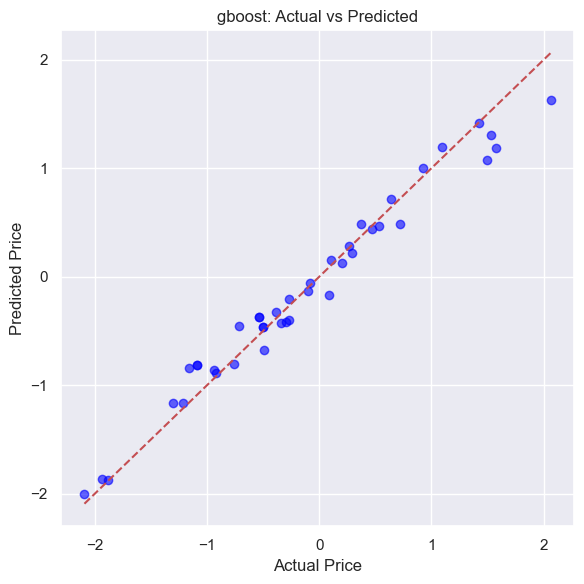

In [400]:
y_pred = gboost.predict(x_validation)
plt.figure(figsize=(6, 6))
plt.scatter(y_validation, y_pred, alpha=0.6, color='blue')
plt.plot([y_validation.min(), y_validation.max()], [y_validation.min(), y_validation.max()], '--r')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("gboost: Actual vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

# XGBoost

## GridSearchCV for XGBoost Regressor

In [ ]:
xgboost = xgb.XGBRegressor(random_state=42)

xgb_param_grid = {
    'n_estimators': [100, 200, 300, 400],              # Number of boosting rounds
    'learning_rate': [0.01, 0.05, 0.1, 0.2],           # Shrinkage rate
    'max_depth': [3, 5, 7, 9],                         # Maximum tree depth
    'min_child_weight': [1, 3, 5],                     # Minimum sum of instance weight (Hessian) in a child
    'subsample': [0.6, 0.8, 1.0],                      # Row subsampling
    'colsample_bytree': [0.6, 0.8, 1.0],               # Feature subsampling
    'gamma': [0, 0.1, 0.3, 0.5],                       # Minimum loss reduction for a split
    'reg_alpha': [0, 0.01, 0.1, 1.0],                  # L1 regularization
    'reg_lambda': [1.0, 1.5, 2.0],                     # L2 regularization
    'booster': ['gbtree'],                             # You can try 'dart' or 'gblinear' too
    'objective': ['reg:squarederror']                  # For regression
}

xgboost_grid_search = GridSearchCV(
    estimator=xgboost,
    param_grid=xgb_param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)
xgboost_grid_search.fit(x_train, y_train)
print("Best XGBoost  Parameters:", xgboost_grid_search.best_params_)
print("Best XGBoost  CV R² Score:", xgboost_grid_search.best_score_)

Fitting 5 folds for each of 82944 candidates, totalling 414720 fits


## RandomSearchCV for XGBoost Regressor

In [9]:
xgboost = xgb.XGBRegressor(random_state=42)
xgb_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=xgb_param_grid,
    n_iter=50,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=2,
    n_jobs=-1,
    random_state=42
)
xgb_search.fit(x_train, y_train)

NameError: name 'xgb_param_grid' is not defined

## Model Tuning

In [ ]:
# XGBoost Regression model - Max depth = 2 after testing various values
xgboost = xgb.XGBRegressor(random_state = 111, max_depth = 3)
xgboost.fit(x_train,y_train)

xgboost_predict_train_data = xgboost.predict(x_train)
xgboost_predict_validation_data = xgboost.predict(x_validation)

xgboost_mse_validate = mean_squared_error(y_validation,xgboost_predict_validation_data)  #  Test Error
xgboost_mse_train = mean_squared_error(y_train,xgboost_predict_train_data)             #  Train Error

xgboost_r2_validate = r2_score(y_validation,xgboost_predict_validation_data)
xgboost_r2_train = r2_score(y_train,xgboost_predict_train_data)

r2_scores = cross_val_score(xgboost, x_train, y_train, cv=10, scoring='r2')
print("Crooss Val score R² for each fold:", r2_scores)
print("Crooss Val score Average R²:", np.mean(r2_scores))

print("\nAccuracy Scores for XGBoost Regression model model on raw data::")
print("->xgboost_mean square error_train_data:", xgboost_mse_train)
print("->xgboost_mean square error_test_data:", xgboost_mse_validate)

print("->xgboost_r2 square error_train_data:", xgboost_r2_train)
print("->xgboost_2 square error_test_data:", xgboost_r2_validate)

print("\nMSE Value are : \nLess than 0 -> Good \n1-2-->Better\n2-3 -> Average")

## XBBoost  actual v/s Predicted comparison

In [ ]:
y_pred = xgboost.predict(x_validation)
plt.figure(figsize=(6, 6))
plt.scatter(y_validation, y_pred, alpha=0.6, color='blue')
plt.plot([y_validation.min(), y_validation.max()], [y_validation.min(), y_validation.max()], '--r')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("XGBoost: Actual vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

# SVM- Support Vector Regression model -linear kernel

## GridSearchCV for SVM-Linear Regressor

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

param_grid1 = {
    'C': [1, 10, 100],
    'epsilon': [0.01, 0.1, 0.2],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

param_grid2 = {
    'C': [0.01, 0.1, 1, 10, 100],       # Regularization strength
    'epsilon': [0.01, 0.1, 0.5, 1.0],   # Epsilon-tube within which no penalty is given
    'loss': ['epsilon_insensitive', 'squared_epsilon_insensitive'],
    'max_iter': [1000, 5000, 10000]     # Max number of iterations
}

param_grid3 = {
    'C': [0.01, 0.1, 1, 10, 100],        # Regularization strength
    'class_weight': [None, 'balanced'], # Handles class imbalance
    'max_iter': [1000, 5000, -1]         # Max iterations (-1 = no limit)
}

svr = SVR(kernel="linear")
grid_search = GridSearchCV(svr, param_grid2, cv=5, scoring='r2', verbose=1, n_jobs=-1)
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid2,scoring='neg_mean_squared_error', cv=5, verbose=2, n_jobs=-1)
grid_search.fit(x_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best R² Score:", grid_search.best_score_)

## Model Tuning

In [ ]:
svr_lin = SVR(kernel ="linear",C=100,epsilon=0.01,gamma="scale")
svr_lin.fit(x_train,y_train)

svr_lin_predict_train_data = svr_lin.predict(x_train)
svr_lin_predict_validation_data = svr_lin.predict(x_validation)

svr_lin_mse_validate = mean_squared_error(y_validation,svr_lin_predict_validation_data)  #  Test Error
svr_lin_mse_train = mean_squared_error(y_train,svr_lin_predict_train_data)             #  Train Error

svr_lin_r2_validate = r2_score(y_validation,svr_lin_predict_validation_data)
svr_lin_r2_train = r2_score(y_train,svr_lin_predict_train_data)

print("\nAccuracy Scores for Support Vector Regression model - Linear kernel model on raw data::")
print("->svr_lin_mean square error_train_data:", svr_lin_mse_train)
print("->svr_lin_mean square error_test_data:", svr_lin_mse_validate)

print("->svr_lin_r2 square error_train_data:", svr_lin_r2_train)
print("->svr_lin_2 square error_test_data:", svr_lin_r2_validate)

print("\nMSE Value are : \nLess than 0 -> Good \n1-2-->Better\n2-3 -> Average")

## svr_lin  actual v/s Predicted comparison

In [ ]:

y_pred = svr_lin.predict(x_validation)
plt.figure(figsize=(6, 6))
plt.scatter(y_validation, y_pred, alpha=0.6, color='blue')
plt.plot([y_validation.min(), y_validation.max()], [y_validation.min(), y_validation.max()], '--r')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("svr_lin: Actual vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

# SVM-Support Vector Regression model - Poly kernel

## GridSearchCV for SVM-Poly Regressor

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Define pipeline with scaling and polynomial kernel SVR
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR(kernel='poly'))
])

# Define hyperparameter grid for tuning
param_grid1 = {
    'svr__degree': [2, 3, 4],
    'svr__C': [0.1, 1, 10],
    'svr__epsilon': [0.01, 0.1],
    'svr__coef0': [0, 1]  # Shifts polynomial curve
}

param_grid2 = {
    'C': [0.1, 1, 10, 100],                    # Regularization strength
    'epsilon': [0.01, 0.1, 0.5, 1.0],          # Epsilon-tube for tolerance in regression
    'degree': [2, 3, 4, 5],                    # Degree of the polynomial kernel
    'coef0': [0.0, 0.5, 1.0],                  # Bias term in the polynomial kernel
    'gamma': ['scale', 'auto', 0.01, 0.1, 1.0] # Kernel coefficient
}

# Perform grid search
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid1,
    scoring='r2',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(x_train, y_train)
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validated R²:", grid_search.best_score_)

## Model Tuning

In [ ]:
svr_poly = SVR(kernel ="poly",epsilon=0.01,gamma="scale",C=0.1,coef0=1,degree=4)
svr_poly.fit(x_train,y_train)

svr_poly_predict_train_data = svr_poly.predict(x_train)
svr_poly_predict_validation_data = svr_poly.predict(x_validation)

svr_poly_mse_validate = mean_squared_error(y_validation,svr_poly_predict_validation_data)  #  Test Error
svr_poly_mse_train = mean_squared_error(y_train,svr_poly_predict_train_data)             #  Train Error

svr_poly_r2_validate = r2_score(y_validation,svr_poly_predict_validation_data)
svr_poly_r2_train = r2_score(y_train,svr_poly_predict_train_data)

print("\nAccuracy Scores for Support Vector Regression model - Poly kernel model on raw data::")
print("->svr_poly_mean square error_train_data:", svr_poly_mse_train)
print("->ssvr_poly_mean square error_test_data:", svr_poly_mse_validate)

print("->svr_poly_r2 square error_train_data:", svr_poly_r2_train)
print("->svr_poly_r2 square error_test_data:", svr_poly_r2_validate)

print("\nMSE Value are : \nLess than 0 -> Good \n1-2-->Better\n2-3 -> Average")

# svr_poly  actual v/s Predicted comparison

In [ ]:
y_pred = svr_poly.predict(x_validation)
plt.figure(figsize=(6, 6))
plt.scatter(y_validation, y_pred, alpha=0.6, color='blue')
plt.plot([y_validation.min(), y_validation.max()], [y_validation.min(), y_validation.max()], '--r')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("svr_poly: Actual vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

# Support Vector Regression model - RBF kernel


## GridSearchCV for SVM-rbf Regressor

In [ ]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR(kernel='rbf'))
])

param_grid = {
    'svr__degree': [2, 3, 4],
    'svr__C': [0.1, 1, 10],
    'svr__epsilon': [0.01, 0.1],
    'svr__coef0': [0, 1]  # Shifts polynomial curve
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='r2',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(x_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validated R²:", grid_search.best_score_)

## Model Tuning

In [ ]:
svr_rbf = SVR(C=10,coef0=0,degree=2,epsilon=0.01,kernel ="rbf")
svr_rbf.fit(x_train,y_train)

svr_rbf_predict_train_data = svr_rbf.predict(x_train)
svr_rbf_predict_validation_data = svr_rbf.predict(x_validation)

svr_rbf_mse_validate = mean_squared_error(y_validation,svr_rbf_predict_validation_data)  #  Test Error
svr_rbf_mse_train = mean_squared_error(y_train,svr_rbf_predict_train_data)             #  Train Error

svr_rbf_r2_validate = r2_score(y_validation,svr_rbf_predict_validation_data)
svr_rbf_r2_train = r2_score(y_train,svr_rbf_predict_train_data)

print("\nAccuracy Scores for Support Vector Regression model - RBF kernel model on raw data::")
print("->svr_rbf_mean square error_train_data:", svr_rbf_mse_train)
print("->v_mean square error_test_data:", svr_rbf_mse_validate)

print("->v_r2 square error_train_data:", svr_rbf_r2_train)
print("->svr_rbf_r2 square error_test_data:", svr_rbf_r2_validate)

print("\nMSE Value are : \nLess than 0 -> Good \n1-2-->Better\n2-3 -> Average")

## svr_rbf  actual v/s Predicted comparison

In [ ]:
y_pred = svr_rbf.predict(x_validation)
plt.figure(figsize=(6, 6))
plt.scatter(y_validation, y_pred, alpha=0.6, color='blue')
plt.plot([y_validation.min(), y_validation.max()], [y_validation.min(), y_validation.max()], '--r')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("svr_rbf: Actual vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

## KNN Model Regressor

In [ ]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

def find_k(x_train, y_train, x_test, y_test):
    error_rate = []

    for i in range(1, 50):
        knn = KNeighborsRegressor(n_neighbors=i)
        knn.fit(x_train, y_train)
        y_pred = knn.predict(x_test)
        error_rate.append(mean_squared_error(y_test, y_pred))

    best_k = np.argmin(error_rate) + 1
    best_mse = error_rate[best_k - 1]

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, 50), error_rate, color='red', linestyle='dashed', 
             marker='o', markersize=5, markerfacecolor='blue')
    plt.axvline(x=best_k, color='green', linestyle='--', label=f'Best K = {best_k}')
    plt.title("Mean Squared Error vs K-Value")
    plt.xlabel("K-Value")
    plt.ylabel("Mean Squared Error")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"Best K: {best_k} with MSE: {best_mse:.4f}")
    return best_k, best_mse


In [ ]:
find_k(x_train, y_train, x_validation, y_validation)

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import numpy as np

# Assume X, y are your features and target arrays

# Standard scaling (if not done already)
scaler = StandardScaler()
#X_scaled = scaler.fit_transform(x_train)

# Try different k values
k_values = range(1, 11)
cv_scores = []

for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    # Negative MSE scoring, use neg_mean_squared_error and take absolute value later
    scores = cross_val_score(knn, x_train, y_train, cv=5, scoring='neg_mean_squared_error')
    mean_score = -np.mean(scores)
    cv_scores.append(mean_score)
    print(f"k={k}, CV Mean MSE: {mean_score:.4f}")

# Find best k
best_k = k_values[np.argmin(cv_scores)]
print(f"Best k based on CV MSE: {best_k}")


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Fit model on entire dataset for residual plot
knn = KNeighborsRegressor(n_neighbors=best_k)
knn.fit(x_train, y_train)
y_pred = knn.predict(x_train)

residuals = y_train - y_pred

plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted values')
plt.ylabel('Residuals (True - Predicted)')
plt.title(f'Residual Plot for KNN Regression (k={best_k})')
plt.show()

# Optionally, print train MSE and R² for quick check
print(f"Train MSE: {mean_squared_error(y_train, y_pred):.4f}")
print(f"Train R²: {r2_score(y_train, y_pred):.4f}")
print(f"Best K: {best_k:.4f}")

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

param_grid = {'n_neighbors': list(range(2, 20))}
grid = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error')
grid.fit(x_train, y_train)

print("Best k:", grid.best_params_)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

# Step 1: Load and prepare your dataset
# Example: medical is a DataFrame with target column named 'target'
# Replace 'target' with the actual name of your target column
#X = medical.drop('price', axis=1)
#y = medical['price']

# Step 2: Train-test split
#x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Step 3: Create pipeline (StandardScaler → PCA → KNN)
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),  # Retain 95% variance
    ('knn', KNeighborsRegressor())
])

# Step 4: Hyperparameter tuning using GridSearchCV
param_grid = {
    'knn__n_neighbors': list(range(2, 15)),
}

grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
grid.fit(x_train, y_train)

# Step 5: Evaluate best model
best_model = grid.best_estimator_
y_pred = best_model.predict(x_validation)

mse = mean_squared_error(y_validation, y_pred)
r2 = r2_score(y_validation, y_pred)

print(f"Best k: {grid.best_params_['knn__n_neighbors']}")
print(f"Test MSE: {mse:.4f}")
print(f"Test R²: {r2:.4f}")


In [ ]:
# Building KNN regressor with k = 2
knn = KNeighborsRegressor(n_neighbors = 2)
knn.fit(x_train,y_train)

knn_predict_train_data = knn.predict(x_train)
knn_predict_validation_data = knn.predict(x_validation)

knn_mse_validate = mean_squared_error(y_validation,knn_predict_validation_data)  #  Test Error
knn_mse_train = mean_squared_error(y_train,knn_predict_train_data)             #  Train Error

knn_r2_validate = r2_score(y_validation,knn_predict_validation_data)
knn_r2_train = r2_score(y_train,knn_predict_train_data)

print("\nAccuracy Scores for KNN Regression model - RBF kernel model on raw data::")
print("->knn_mean square error_train_data:", knn_mse_train)
print("->knn_mean square error_test_data:", knn_mse_validate)

print("->knn_r2 square error_train_data:", knn_r2_train)
print("->knn_r2 square error_test_data:", knn_r2_validate)

print("\nMSE Value are : \nLess than 0 -> Good \n1-2-->Better\n2-3 -> Average")

## Full Comparison Script Ensemble Comparison


📊 Model Performance Comparison:

Decision Tree:
  -> Train MSE: 0.1084
  -> Test MSE: 0.1644
  -> Train R²: 0.8919
  -> Test R²: 0.8299

Random Forest:
  -> Train MSE: 0.0671
  -> Test MSE: 0.0685
  -> Train R²: 0.9331
  -> Test R²: 0.9291

Gradient Boosting:
  -> Train MSE: 0.0147
  -> Test MSE: 0.0302
  -> Train R²: 0.9854
  -> Test R²: 0.9688

XGBoost:
  -> Train MSE: 0.0000
  -> Test MSE: 0.0089
  -> Train R²: 1.0000
  -> Test R²: 0.9908

svr_poly:
  -> Train MSE: 0.0235
  -> Test MSE: 0.0287
  -> Train R²: 0.9766
  -> Test R²: 0.9703

svr_lin:
  -> Train MSE: 0.1417
  -> Test MSE: 0.0824
  -> Train R²: 0.8587
  -> Test R²: 0.9147

svr_rbf:
  -> Train MSE: 0.0012
  -> Test MSE: 0.0250
  -> Train R²: 0.9988
  -> Test R²: 0.9741

linear_model:
  -> Train MSE: 0.1149
  -> Test MSE: 0.0754
  -> Train R²: 0.8854
  -> Test R²: 0.9220

lasso:
  -> Train MSE: 0.1174
  -> Test MSE: 0.0722
  -> Train R²: 0.8829
  -> Test R²: 0.9253

ridge:
  -> Train MSE: 0.1178
  -> Test MSE: 0.0724
  -> T

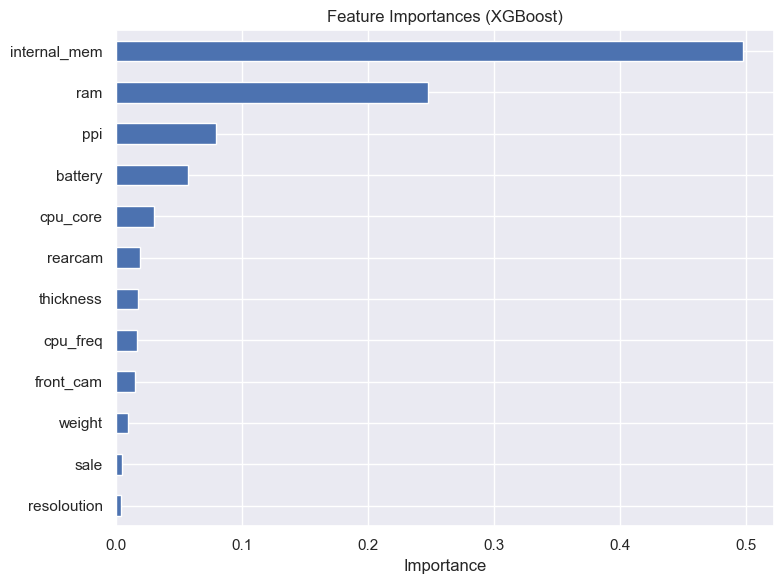

In [396]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Sample split – replace X, y with your actual dataset
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model configurations
models = {
    'Decision Tree': DecisionTreeRegressor(max_depth=5, min_samples_leaf=10, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators = 400, max_features= "sqrt",min_samples_leaf=5 ,random_state = 1, max_depth = 7),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators = 400, max_depth = 3,learning_rate=0.01,min_samples_leaf=5, random_state = 42),
    'XGBoost' : xgb.XGBRegressor(random_state = 111, max_depth = 3),
    'svr_poly': SVR(kernel ="poly",epsilon=0.01,gamma="scale",C=0.1,coef0=1,degree=4),
    'svr_lin' : SVR(kernel ="linear",C=100,epsilon=0.01,gamma="scale"),
    'svr_rbf' : SVR(C=10,coef0=0,degree=2,epsilon=0.01,kernel ="rbf"),
    'linear_model' : LinearRegression(),
    'lasso' : LassoCV(cv=5),#alpha=0.02310129700083160),
    'ridge' : RidgeCV(cv=5),
    'elastic' : ElasticNet(alpha=0.0012328467394420659)
}

# Dictionary to hold scores
results = {}

# Train and evaluate each model
for name, model in models.items():
    model.fit(x_train, y_train)
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_validation)

    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_validation, y_test_pred)
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_validation, y_test_pred)

    results[name] = {
        'Train MSE': mse_train,
        'Test MSE': mse_test,
        'Train R²': r2_train,
        'Test R²': r2_test,
        'Model': model
    }

# Print results
print("\n📊 Model Performance Comparison:\n")
for name, metrics in results.items():
    print(f"{name}:")
    print(f"  -> Train MSE: {metrics['Train MSE']:.4f}")
    print(f"  -> Test MSE: {metrics['Test MSE']:.4f}")
    print(f"  -> Train R²: {metrics['Train R²']:.4f}")
    print(f"  -> Test R²: {metrics['Test R²']:.4f}")
    print("")

# Feature importance plot for the best test R² model
best_model_name = max(results, key=lambda x: results[x]['Test R²'])
best_model = results[best_model_name]['Model']

# Plot if model supports feature importances
if hasattr(best_model, "feature_importances_"):
    importances = best_model.feature_importances_
    feat_names = x_train.columns if hasattr(x_train, 'columns') else [f'Feature {i}' for i in range(x_train.shape[1])]
    pd.Series(importances, index=feat_names).sort_values(ascending=True).plot(kind='barh', figsize=(8, 6))
    plt.title(f"Feature Importances ({best_model_name})")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()
else:
    print(f"{best_model_name} does not support feature importances.")

## Compare the Actual v/s Predicted visualization


In [ ]:
xgboost

In [ ]:
final_modell = xgboost